# Analysis of results for devign, bifi, exception classification

In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import itertools
import matplotlib
import warnings
from scipy.stats import ttest_rel, wilcoxon, mannwhitneyu

# Use TrueType font instead of Type3 (ESEC/FSE requirement)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')

## Paths

In [2]:
combinations = ['cutoff_layers_one_layer_cls', 
                'one_layer_cls',
                'one_layer_w_sum_tokens',
                'one_layer_max_pool_tokens',
                'w_sum_tokens_w_sum_layers',
                'max_pool_layers_w_sum_tokens',
                'w_sum_layers_w_sum_tokens',
                'max_pool_tokens_w_sum_layers',
                'max_pool_layers_max_pool_tokens',
                'w_sum_cls',
                'max_pool_cls'
                ]

one_layer_combinations = [c for c in combinations if 'one_layer' in c]
one_layer_combinations = ['_'.join(p) for p in list(itertools.product(one_layer_combinations, [str(i) for i in range(1,13)]))]
combination_long_names = [c for c in combinations if not('one_layer' in c)] + one_layer_combinations

combination_long_names = [c for c in combination_long_names if 'cls' in c] + ['_zero_out_sp_tokens_'.join(p) for p in list(itertools.product([c for c in combination_long_names if not('cls' in c)], ['True', 'False']))]

single_layers = list(range(1,13))
single_layers_cutoff = list(range(1,12))

seeds = list(range(1,10)) + [42]

zero_out_special_tokens = [True, False]

default_sp_tokens_to_zero = False

experiment_names = ['devign', 'reveal', 'bifi', 'exception']

alpha=0.05

In [3]:
table_dir = Path('../output/tables')
plot_dir = Path('../output/figures/')

In [4]:
table = {}
for name in experiment_names:
    table[name] = pd.read_csv(table_dir / f'mlflow_{name}.csv')
    
for name in experiment_names:
    table[name].dropna(subset=['metrics.acc_test'], inplace=True)
    table[name].drop_duplicates(
        subset=['params.combination_type', 
                'params.hidden_layer_to_use',
                'params.seed', 
                'params.epochs', 
                'params.not_special_tokens_to_zero'], keep='last', inplace=True)

# Naming for figures

In [5]:
sp_tokens_suffix = '_zero_out_sp_tokens'

sp_tokens_suffix_on_plot = ',\nspecial tokens = 0'

plot_experiment_names = {
    'devign': 'Devign',
    'bifi': 'BIFI',
    'exception': 'Exception Type',
    'reveal': 'ReVeal'
}

experiments = {
    'binary': ['devign', 'reveal'],
    'multiclass': ['bifi', 'exception']
}

plot_combination_names = {
    'cutoff_layers_one_layer_cls' : '(xii) {l} layers',
    'one_layer_w_sum_tokens' : '(ix) w sum tokens, layer {l}',
    'one_layer_max_pool_tokens' : '(v) max pool tokens, layer {l}',
    'one_layer_cls' : '(ii) CLS, layer {l}',
    'w_sum_tokens_w_sum_layers' : '(x) w sum tokens, w sum layers',
    'max_pool_layers_w_sum_tokens' : '(vii) max pool layers, w sum tokens',
    'w_sum_layers_w_sum_tokens' : '(xi) w sum layers, w sum tokens',
    'max_pool_tokens_w_sum_layers' : '(viii) max pool tokens, w sum layers',
    'max_pool_layers_max_pool_tokens' : '(vi) max pool layers,\nmax pool tokens',
    'w_sum_cls' : '(iv) w sum CLS tokens',
    'max_pool_cls' : '(iii) max pool CLS tokens',
    'baseline' : '(i) baseline,\nCLS, layer 12',
    'one_layer_w_sum_tokens' + sp_tokens_suffix : '(ix) w sum tokens, layer {l}' + sp_tokens_suffix_on_plot,
    'one_layer_max_pool_tokens' + sp_tokens_suffix: '(v) max pool tokens, layer {l}' + sp_tokens_suffix_on_plot,
    'w_sum_tokens_w_sum_layers' + sp_tokens_suffix: '(x) w sum tokens, w sum layers' + sp_tokens_suffix_on_plot,
    'max_pool_layers_w_sum_tokens' + sp_tokens_suffix: '(vii) max pool layers, w sum tokens' + sp_tokens_suffix_on_plot,
    'w_sum_layers_w_sum_tokens' + sp_tokens_suffix: '(xi) w sum layers, w sum tokens' + sp_tokens_suffix_on_plot,
    'max_pool_tokens_w_sum_layers' + sp_tokens_suffix: '(viii) max pool tokens, w sum layers' + sp_tokens_suffix_on_plot,
    'max_pool_layers_max_pool_tokens' + sp_tokens_suffix: '(vi) max pool layers, max pool tokens' + sp_tokens_suffix_on_plot
}

plot_metric_names = {
    'acc_test' : 'accuracy', 
    'balanced_acc_test': 'balanced accuracy', 
    'f1_macro_test': 'F1-score macro', 
    'f1_weighted_test': 'F1 (w)',
    'f1_micro_test': 'F1'
}

combinations = ['cutoff_layers_one_layer_cls', 
                'one_layer_cls',
                'max_pool_cls', 
                'w_sum_cls',
                'one_layer_max_pool_tokens',
                'max_pool_layers_max_pool_tokens',
                'max_pool_layers_w_sum_tokens',
                'max_pool_tokens_w_sum_layers',
                'one_layer_w_sum_tokens',
                'w_sum_tokens_w_sum_layers',
                'w_sum_layers_w_sum_tokens',
                ]
plot_metric_by_experiment_name = {
    'devign': 'acc_test',
    'bifi': 'acc_test',#'f1_weighted_test',
    'exception': 'f1_weighted_test',
    'reveal': 'f1_micro_test'
}



heatmap_combination_names = {
    'cutoff_layers_one_layer_cls' : '(xii) model with l<L layers,\n last layer CLS token',
    'one_layer_w_sum_tokens' : '(ix) w sum all tokens',
    'one_layer_max_pool_tokens' : '(v) max pool all tokens',
    'one_layer_w_sum_tokens' + sp_tokens_suffix : '(ix) w sum code tokens',
    'one_layer_max_pool_tokens' + sp_tokens_suffix: '(v) max pool code tokens',
    'one_layer_cls' : '(ii) CLS token layer $l$',
    'w_sum_tokens_w_sum_layers' : '(x) w sum all tokens, w sum layers',
    'max_pool_layers_w_sum_tokens' : '(vii) max pool layers, w sum all tokens',
    'w_sum_layers_w_sum_tokens' : '(xi) w sum layers, w sum all tokens',
    'max_pool_tokens_w_sum_layers' : '(viii) max pool all tokens, w sum layers',
    'max_pool_layers_max_pool_tokens' : '(vi) max pool layers, max pool all tokens',
    'w_sum_tokens_w_sum_layers' + sp_tokens_suffix: '(x) w sum code tokens, w sum layers',
    'max_pool_layers_w_sum_tokens' + sp_tokens_suffix: '(vii) max pool layers, w sum code tokens',
    'w_sum_layers_w_sum_tokens' + sp_tokens_suffix: '(xi) w sum layers, w sum code tokens',
    'max_pool_tokens_w_sum_layers' + sp_tokens_suffix: '(viii) max pool code tokens, w sum layers',
    'max_pool_layers_max_pool_tokens' + sp_tokens_suffix: '(vi) max pool layers, max pool code tokens',
    'w_sum_cls' : '(iv) w sum CLS tokens',
    'max_pool_cls' : '(iii) max pool CLS tokens',
    'baseline' : '(i) baseline,\nCLS, layer 12'
}

def scale_by_100(value_list):
    return list(map(lambda x: x*100., value_list))

In [6]:
def update_with_better_data_and_labels(data, labels, table, name, layer, sp_tokens, c, metric, p_values, baseline, plot_combination_names=plot_combination_names):
    
    baseline_mean = np.mean(baseline)
    values = table[name].loc[(table[name].loc[:, 'params.combination_type'] == c) & \
                                                    (table[name].loc[:, 'params.hidden_layer_to_use'] == layer) & \
                                                      (table[name].loc[:, 'params.epochs'] == 10) & \
                                                    (table[name].loc[:, 'params.not_special_tokens_to_zero'] == sp_tokens), 
                                                      f'metrics.{metric}'].values.tolist()
    
    if len(values) != 10:
        print(f'{name}: {c} layer {layer} not_special_tokens_to_zero={sp_tokens} has {len(values)} values')
    
    if np.mean(values) > baseline_mean:
        data[name][metric].append(values)
        label = plot_combination_names[c + (sp_tokens_suffix if sp_tokens==False and not 'cls' in c else '')].format(l=layer)
        labels[name][metric].append(label)
        
        try:
            stat = wilcoxon(values, baseline)
            p_values[name][metric].append(stat.pvalue)
        except: 
            p_values[name][metric].append('n/a')

In [7]:
def update_all_data_and_labels(data, labels, table, name, layer, sp_tokens, c, metric, p_values, baseline, sp_tokens_text=False, plot_combination_names=plot_combination_names):
    
    baseline_mean = np.mean(baseline)
    values = table[name].loc[(table[name].loc[:, 'params.combination_type'] == c) & \
                                                    (table[name].loc[:, 'params.hidden_layer_to_use'] == layer) & \
                                                      (table[name].loc[:, 'params.epochs'] == 10) & \
                                                    (table[name].loc[:, 'params.not_special_tokens_to_zero'] == sp_tokens), 
                                                      f'metrics.{metric}'].values.tolist()
    
    if len(values) != 10:
        print(f'{name}: {c} layer {layer} not_special_tokens_to_zero={sp_tokens} has {len(values)} values')
        
    data[name][metric].append(values)
    label = plot_combination_names[c + (sp_tokens_suffix if not sp_tokens and sp_tokens_text and not 'cls' in c else '')].format(l=layer)# + (sp_tokens_suffix_on_plot if not sp_tokens and sp_tokens_text and not 'cls' in c else '')
    labels[name][metric].append(label)
    if np.mean(values) > baseline_mean:
        try:
            stat = wilcoxon(values, baseline)
            p_values[name][metric].append(stat.pvalue)
        except: 
            p_values[name][metric].append('n/a')
    else:
        p_values[name][metric].append('')

In [8]:
from datetime import timedelta
import datetime
import time

def get_ptime(time_str):
    return time.strptime(time_str.split('+')[0].split('.')[0], '%Y-%m-%d %H:%M:%S')
    
def total_seconds(x):
    x = get_ptime(x)
    return datetime.timedelta(days=x.tm_mday, hours=x.tm_hour, minutes=x.tm_min, seconds=x.tm_sec).total_seconds()

def get_total_time_in_seconds(start_time_str, end_time_str):
    return total_seconds(end_time_str) - total_seconds(start_time_str)

def get_time_values_in_seconds_from_table(table, name, layer, sp_tokens, c):
    start_times = get_values(table, name, layer, sp_tokens, c, 'start_time')
    end_times = get_values(table, name, layer, sp_tokens, c, 'end_time')
    values = []
    for start_time, end_time in zip(start_times, end_times):
        values.append(get_total_time_in_seconds(start_time, end_time))
    
    return values

def format_time_to_seconds(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

def get_time_hh_mm_ss(sec: float) -> str:

    # create timedelta and convert it into string
    td_str = str(timedelta(seconds=sec))

    # split string into individual component
    x = td_str.split(':')
    return f'{x[0]}:{x[1]}:{x[2]}'

def get_values(table, name, layer, sp_tokens, c, metric):
    values = table[name].loc[(table[name].loc[:, 'params.combination_type'] == c) & \
                                                    (table[name].loc[:, 'params.hidden_layer_to_use'] == layer) & \
                                                      (table[name].loc[:, 'params.epochs'] == 10) & \
                                                    (table[name].loc[:, 'params.not_special_tokens_to_zero'] == sp_tokens), 
                                                      f'{metric}'].values.tolist()
    seeds = table[name].loc[(table[name].loc[:, 'params.combination_type'] == c) & \
                                                    (table[name].loc[:, 'params.hidden_layer_to_use'] == layer) & \
                                                      (table[name].loc[:, 'params.epochs'] == 10) & \
                                                    (table[name].loc[:, 'params.not_special_tokens_to_zero'] == sp_tokens), 
                                                      f'params.seed'].values.tolist()
    if len(values) != 10:
        print(f'{name} {c} {layer}: {len(values)} - unexpected # values')
    diff_seeds = set(seeds) - set([42] + list(range(1,10)))
    if len(diff_seeds) > 0:
        print(f'{name} {c} {layer}: {len(values)} not covered seeds: {diff_seeds}')
    return values

def get_factor_vs_baseline(table, name, layer, sp_tokens, c, metric, baseline):
    values = table[name].loc[(table[name].loc[:, 'params.combination_type'] == c) & \
                                                    (table[name].loc[:, 'params.hidden_layer_to_use'] == layer) & \
                                                      (table[name].loc[:, 'params.epochs'] == 10) & \
                                                    (table[name].loc[:, 'params.not_special_tokens_to_zero'] == sp_tokens), 
                                                      f'{metric}'].values.tolist()
    
    seeds = table[name].loc[(table[name].loc[:, 'params.combination_type'] == c) & \
                                                    (table[name].loc[:, 'params.hidden_layer_to_use'] == layer) & \
                                                      (table[name].loc[:, 'params.epochs'] == 10) & \
                                                    (table[name].loc[:, 'params.not_special_tokens_to_zero'] == sp_tokens), 
                                                      f'params.seed'].values.tolist()
    if len(values) != 10:
        print(f'{name} {c} {layer}: {len(values)} - unexpected # values')
    diff_seeds = set(seeds) - set([42] + list(range(1,10)))
    if len(diff_seeds) > 0:
        print(f'{name} {c} {layer}: {len(values)} not covered seeds: {diff_seeds}')
        
    if 'total_time' in metric:
        values = list(map(format_time_to_seconds, values))
    if len(values) == 10:
        return np.mean(values) / np.mean(baseline) * 100
    else:
        print(f'{c} {layer}: {len(values)} - unexpected # values')
        return 'n/a'

# Detect missing experiments

In [9]:
print('Missing experiments:')

default_sp_tokens_to_zero = False

for name in experiment_names:
    table[name].dropna(subset=['metrics.acc_test'], inplace=True)
    table[name].drop_duplicates(
        subset=['params.combination_type', 
                'params.hidden_layer_to_use',
                'params.seed', 
                'params.epochs', 
                'params.not_special_tokens_to_zero',
                'metrics.acc_test'], keep='last', inplace=True)
    for seed in seeds:
        for c in combinations:
            if 'one_layer' in c:
                layers = single_layers_cutoff if 'cutoff' in c else single_layers
                for l in layers:
                    if 'cls' in c:
                        acc = table[name].loc[(table[name].loc[:, 'params.combination_type'] == c) & \
                                            (table[name].loc[:, 'params.hidden_layer_to_use'] == l) & \
                                            (table[name].loc[:, 'params.seed'] == seed) & \
                                              (table[name].loc[:, 'params.epochs'] == 10) & \
                                            (table[name].loc[:, 'params.not_special_tokens_to_zero'] == default_sp_tokens_to_zero), 
                                              'metrics.acc_test']
                        if len(acc) == 0 or acc is None or  acc.values == [None]: 
                            print(f'Missing: {name} seed {seed} {c} {l} not_special_tokens_to_zero={default_sp_tokens_to_zero}')
                    else:
                        for sp_tokens in zero_out_special_tokens:
                            acc = table[name].loc[(table[name].loc[:, 'params.combination_type'] == c) & \
                                                (table[name].loc[:, 'params.hidden_layer_to_use'] == l) & \
                                                (table[name].loc[:, 'params.seed'] == seed) & \
                                              (table[name].loc[:, 'params.epochs'] == 10) & \
                                                (table[name].loc[:, 'params.not_special_tokens_to_zero'] == sp_tokens), 
                                                  'metrics.acc_test']
                            if len(acc) == 0 or acc is None or acc.values == [None]: 
                                print(f'Missing: {name} seed {seed} {c} {l} not_special_tokens_to_zero={sp_tokens}')
            else:
                l = 12
                if 'cls' in c:
                    acc = table[name].loc[(table[name].loc[:, 'params.combination_type'] == c) & \
                                        (table[name].loc[:, 'params.hidden_layer_to_use'] == l) & \
                                        (table[name].loc[:, 'params.seed'] == seed) & \
                                              (table[name].loc[:, 'params.epochs'] == 10) & \
                                        (table[name].loc[:, 'params.not_special_tokens_to_zero'] == default_sp_tokens_to_zero), 
                                          'metrics.acc_test']
                    if len(acc) == 0 or acc is None or acc.values == [None]: 
                        print(f'Missing: {name} seed {seed} {c} {l} not_special_tokens_to_zero={default_sp_tokens_to_zero}')
                else:
                    for sp_tokens in zero_out_special_tokens:

                        acc = table[name].loc[(table[name].loc[:, 'params.combination_type'] == c) & \
                                            (table[name].loc[:, 'params.hidden_layer_to_use'] == l) & \
                                            (table[name].loc[:, 'params.seed'] == seed) & \
                                              (table[name].loc[:, 'params.epochs'] == 10) & \
                                            (table[name].loc[:, 'params.not_special_tokens_to_zero'] == sp_tokens), 
                                              'metrics.acc_test']
                        if len(acc) == 0 or acc is None or acc.values == [None]: 
                            print(f'Missing: {name} seed {seed} {c} {l} not_special_tokens_to_zero={sp_tokens}')


Missing experiments:


# Pruned models

## Table for each dataset

- metric: +/-x compared to baseline, i.e., to using the CLS token from the last layer
- \# params: % of total
- time: total time as is

In [10]:
layer_baseline = 12
c_baseline = 'one_layer_cls'
c = 'cutoff_layers_one_layer_cls'

dfs = {}

for name in experiment_names:
    print(name)
    metric = plot_metric_by_experiment_name[name]

    cols = ['# layers']
    rows = list(range(1,13))
    dfs[name] = pd.DataFrame(index=rows, columns=cols, data=None)

    for m, col in zip(
        ['params.hidden_layer_to_use', 
         'params.num_trainable_parameters', 
         '', 
         f'metrics.time_train_min', 
         f'metrics.time_train_min'],
        ['# layers', 
         '# parameters, % of baseline', 
         'Total Time', 
         'Avg train time / epoch', 
         'Avg train speed up']):
        
        if col == 'Total Time':
            baseline_values = get_time_values_in_seconds_from_table(table, name, layer_baseline, default_sp_tokens_to_zero, c_baseline)
            dfs[name].loc[layer_baseline, col] = get_time_hh_mm_ss(round(np.mean(baseline_values))).split('.')[0]
            
            for layer in range(11, 0, -1):            
                values =  get_time_values_in_seconds_from_table(table, name, layer, default_sp_tokens_to_zero, c)
                dfs[name].loc[layer, col] = get_time_hh_mm_ss(round(np.mean(values))).split('.')[0]
                
        elif '# param' in col:
            baseline_values = get_values(table, name, layer_baseline, default_sp_tokens_to_zero, c_baseline, m)
            dfs[name].loc[layer_baseline, col] = float(np.mean(baseline_values))

            for layer in range(11, 0, -1):            
                # get experiment factor
                dfs[name].loc[layer, col] = float(round(get_factor_vs_baseline(table, name, layer, default_sp_tokens_to_zero, c, m, baseline_values), 0))

        elif col == 'Avg train time / epoch':
            baseline_values = get_values(table, name, layer_baseline, default_sp_tokens_to_zero, c_baseline, m)
            dfs[name].loc[layer_baseline, col] = get_time_hh_mm_ss(round(np.mean(list(map(lambda x: x * 60., baseline_values)))))[3:]
            for layer in range(11, 0, -1):            
                # end-start
                values =  get_values(table, name, layer, default_sp_tokens_to_zero, c, m)
                dfs[name].loc[layer, col] = get_time_hh_mm_ss(round(np.mean(list(map(lambda x: x * 60., values))))).split('.')[0][3:]
                
        elif col == 'Avg train speed up':
            baseline_values = get_values(table, name, layer_baseline, default_sp_tokens_to_zero, c_baseline, m)
            baseline_mean = np.mean(list(map(lambda x: x * 60., baseline_values)))
            dfs[name].loc[layer_baseline, col] = get_time_hh_mm_ss(round(baseline_mean))[3:]
            for layer in range(11, 0, -1):            
                values =  get_values(table, name, layer, default_sp_tokens_to_zero, c, m)
                speedup = round(baseline_mean / np.mean(list(map(lambda x: x * 60., values))),1)
                dfs[name].loc[layer, col] = f'{speedup}x'
            
        else: 
            baseline_values = get_values(table, name, layer_baseline, default_sp_tokens_to_zero, c_baseline, m)
            dfs[name].loc[layer_baseline, col] = float(round(np.mean(baseline_values), 2))
            
            for layer in range(11, 0, -1):            
                dfs[name].loc[layer, col] = float(round(np.mean(get_values(table, name, layer, default_sp_tokens_to_zero, c, m)), 2))
                
    for metric in ['acc_test', 'balanced_acc_test', 'f1_micro_test', 'f1_weighted_test']:
        for m, col in zip([f'metrics.{metric}', f'metrics.{metric}'], [f'{plot_metric_names[metric]}', f'p-value {plot_metric_names[metric]}']):
            
            if col == f'{plot_metric_names[metric]}':
                baseline_values = get_values(table, name, layer_baseline, default_sp_tokens_to_zero, c_baseline, m)
                dfs[name].loc[layer_baseline, col] = float(round(np.mean(list(map(lambda x: x*(1 + 99*int(m==f'metrics.{metric}')), 
                                                                              baseline_values))), 2))

                for layer in range(11, 0, -1):
                    mean_diff = float(round(np.mean(list(map(lambda x: x*(1 + 99*int(m==f'metrics.{metric}')), 
                                                                             get_values(table, name, layer, default_sp_tokens_to_zero, c, m)))), 1)) \
                        - dfs[name].loc[layer_baseline, col]
                    sign = '+' if mean_diff > 0. else ''
                    dfs[name].loc[layer, col] = f'{sign}{round(mean_diff, 1)}'
            
            elif f'p-value' in col:
                baseline_values = get_values(table, name, layer_baseline, default_sp_tokens_to_zero, c_baseline, m)
                for layer in range(11, 0, -1):            
                    values =  get_values(table, name, layer, default_sp_tokens_to_zero, c, m)
                    stat = wilcoxon(values, baseline_values)
                    dfs[name].loc[layer, col] = stat.pvalue
                    if dfs[name].loc[layer, col] < alpha and np.mean(values) > np.mean(baseline_values):
                        dfs[name].loc[layer, plot_metric_names[metric]] = '\\bf{' + str(dfs[name].loc[layer, plot_metric_names[metric]]) + '}'  
                    elif dfs[name].loc[layer, col] > alpha and np.mean(values) < np.mean(baseline_values):
                        dfs[name].loc[layer, plot_metric_names[metric]] += '*'
                                      
                
    dfs[name].set_index('# layers', inplace=True)
    dfs[name].sort_index(ascending=False, inplace=True)
    
    # save df (change \\bf and {} to something else next to pvalue)
    # smaller_models_filepath = Path(f'../output/tables/smaller_models_{name}.xlsx')
    # dfs[name].to_excel(smaller_models_filepath)



devign
reveal
bifi
exception


In [11]:
dfs[name]

,"# parameters, % of baseline",Total Time,Avg train time / epoch,Avg train speed up,accuracy,p-value accuracy,balanced accuracy,p-value balanced accuracy,F1,p-value F1,F1 (w),p-value F1 (w)
# layers,,,,,,,,,,,,
12.0,124661012.0,1:17:52,7:22,7:22,75.39,NaN,64.71,NaN,75.39,NaN,75.3,NaN
11.0,94.0,1:10:14,6:33,1.1x,-1.0,0.013672,-1.0*,0.064453,-1.0,0.013672,-1.0,0.019531
10.0,89.0,1:04:43,6:01,1.2x,-1.8,0.003906,-2.2,0.001953,-1.8,0.003906,-1.8,0.003906
9.0,83.0,0:59:01,5:29,1.3x,-2.2,0.001953,-3.3,0.001953,-2.2,0.001953,-2.3,0.001953
8.0,77.0,0:52:37,4:55,1.5x,-3.0,0.001953,-4.3,0.001953,-3.0,0.001953,-3.0,0.001953
7.0,72.0,0:46:38,4:20,1.7x,-4.1,0.001953,-6.8,0.001953,-4.1,0.001953,-4.4,0.001953
6.0,66.0,0:41:15,3:50,1.9x,-6.1,0.001953,-9.4,0.001953,-6.1,0.001953,-6.6,0.001953
5.0,60.0,0:35:11,3:15,2.3x,-7.3,0.001953,-10.8,0.001953,-7.3,0.001953,-7.7,0.001953
4.0,55.0,0:29:19,2:41,2.7x,-8.3,0.001953,-14.4,0.001953,-8.3,0.001953,-9.2,0.001953


## Table 2
Combined result from 4 tables, one for each dataset

In [12]:
# columns: 
# 2: avg train time/epoch, 
# 3: avg train speed up
# 4: accuracy
# 10: F1 (w) = F1-weighted
smaller_models_df = pd.concat([dfs[name].iloc[:, [2, 3, 4, 10]] for name in experiment_names], 
                              axis=1, keys=experiment_names)

# save aggregated table to file
# change \\bf and {} to something else next to pvalue
# smaller_models_agg_filepath = Path(f'../output/tables/smaller_models.xlsx')
# smaller_models_df.to_excel(smaller_models_agg_filepath)

# print latex table for the paper (without effect size coloring)
# print(smaller_models_df.to_latex())

In [13]:
smaller_models_df

devign                                           \
         Avg train time / epoch Avg train speed up   accuracy     F1 (w)   
# layers                                                                   
12.0                       8:50               8:50      61.74       60.4   
11.0                       8:03               1.1x       +0.3      -0.1*   
10.0                       7:13               1.2x       +0.1       +0.3   
9.0                        6:40               1.3x       +0.3       +0.5   
8.0                        5:52               1.5x  \bf{+0.9}       +1.1   
7.0                        5:23               1.6x  \bf{+1.4}  \bf{+2.2}   
6.0                        4:54               1.8x  \bf{+1.4}  \bf{+2.0}   
5.0                        4:03               2.2x  \bf{+1.0}  \bf{+1.5}   
4.0                        3:22               2.6x  \bf{+1.2}  \bf{+1.6}   
3.0                        2:41               3.3x  \bf{+2.0}  \bf{+2.4}   
2.0                        2:00               4.4x  \bf{+1.0}  \bf{+1.9}   
1.0                        1:18               6.8x       -3.2       -2.3   

                         reveal                                           \
         Avg train time / epoch Avg train speed up   accuracy     F1 (w)   
# layers                                                                   
12.0                       6:57               6:57      89.15      88.53   
11.0                       6:56               1.0x  \bf{+0.6}       +0.3   
10.0                       6:20               1.1x       +0.2      -0.0*   
9.0                        5:53               1.2x       +0.3      -0.1*   
8.0                        5:15               1.3x       +0.2      -0.1*   
7.0                        4:44               1.5x       +0.3       +0.2   
6.0                        4:25               1.6x       +0.3       +0.1   
5.0                        3:45               1.9x       +0.1       +0.2   
4.0                        3:06               2.2x      -0.2*       +0.2   
3.0                        2:28               2.8x       +0.1       +0.3   
2.0                        1:52               3.7x       +0.4  \bf{+0.6}   
1.0                        1:13               5.7x  \bf{+0.8}       -1.2   

                           bifi                                     \
         Avg train time / epoch Avg train speed up accuracy F1 (w)   
# layers                                                             
12.0                       8:41               8:41     96.7   96.7   
11.0                       7:07               1.2x    -0.1*  -0.1*   
10.0                       6:22               1.4x     -0.3   -0.3   
9.0                        5:46               1.5x     -0.5   -0.5   
8.0                        5:13               1.7x     -0.6   -0.6   
7.0                        4:43               1.8x     -1.1   -1.1   
6.0                        4:10               2.1x     -1.7   -1.7   
5.0                        3:31               2.5x     -3.0   -3.0   
4.0                        2:53               3.0x     -6.8   -6.8   
3.0                        2:15               3.8x    -11.3  -11.3   
2.0                        1:34               5.5x    -14.7  -14.8   
1.0                        0:58               9.0x    -27.2  -27.3   

                      exception                                     
         Avg train time / epoch Avg train speed up accuracy F1 (w)  
# layers                                                            
12.0                       7:22               7:22    75.39   75.3  
11.0                       6:33               1.1x     -1.0   -1.0  
10.0                       6:01               1.2x     -1.8   -1.8  
9.0                        5:29               1.3x     -2.2   -2.3  
8.0                        4:55               1.5x     -3.0   -3.0  
7.0                        4:20               1.7x     -4.1   -4.4  
6.0                        3:50               1.9x     -6.1   -6.6  
5.

In [14]:
# df_smaller_models = pd.read_excel(smaller_models_filepath.parent / 'smaller_models.xlsx', index_col=0, header=[0,1,2,3,4], sheet_name='Sheet3')
# print(df_smaller_models.to_latex(float_format="{:0.1f}".format))

## Effect size

In [15]:
def a12(lst1,lst2,rev=True):
    """VDA with A12. Reference: https://gist.github.com/timm/5630491"""
    more = same = 0.0
    for x in lst1:
        for y in lst2:
            if   x==y : same += 1
            elif rev     and x > y : more += 1
            elif not rev and x < y : more += 1
    score = (more + 0.5*same)  / (len(lst1)*len(lst2))
    return max(score, 1. - score)

In [16]:
layer_baseline = 12
c_baseline = 'one_layer_cls'
c = 'cutoff_layers_one_layer_cls'

dfs_effect_size = {}

for name in experiment_names:
    print(name)
    
    metric = plot_metric_by_experiment_name[name]

    cols = ['# layers']
    rows = list(range(1,13))
    dfs_effect_size[name] = pd.DataFrame(index=rows, columns=cols, data=None)

    for m, col in zip(
        ['params.hidden_layer_to_use', 
         'params.num_trainable_parameters', 
         '', 
         f'metrics.time_train_min', 
         f'metrics.time_train_min'],
        ['# layers', 
         '# parameters, % of baseline', 
         'Total Time', 
         'Avg train time / epoch', 
         'Avg train speed up']):
        
        if col == 'Total Time':
            baseline_values = get_time_values_in_seconds_from_table(table, name, layer_baseline, default_sp_tokens_to_zero, c_baseline)
            
            for layer in range(11, 0, -1):            
                values =  get_time_values_in_seconds_from_table(table, name, layer, default_sp_tokens_to_zero, c)
                dfs_effect_size[name].loc[layer, col] = a12(values, baseline_values)
                
        elif '# param' in col:
            baseline_values = get_values(table, name, layer_baseline, default_sp_tokens_to_zero, c_baseline, m)

            for layer in range(11, 0, -1):            
                # get experiment factor
                values =  get_values(table, name, layer, default_sp_tokens_to_zero, c, m)
                dfs_effect_size[name].loc[layer, col] =  a12(values, baseline_values)

        elif col == 'Avg train time / epoch':
            baseline_values = get_values(table, name, layer_baseline, default_sp_tokens_to_zero, c_baseline, m)
            for layer in range(11, 0, -1):            
                # end-start
                values =  get_values(table, name, layer, default_sp_tokens_to_zero, c, m)
                dfs_effect_size[name].loc[layer, col] = a12(values, baseline_values)
            
        else: 
            baseline_values = get_values(table, name, layer_baseline, default_sp_tokens_to_zero, c_baseline, m)
            dfs_effect_size[name].loc[layer_baseline, col] = float(round(np.mean(baseline_values), 2))
            
            for layer in range(11, 0, -1):            
                dfs_effect_size[name].loc[layer, col] = float(round(np.mean(get_values(table, name, layer, default_sp_tokens_to_zero, c, m)), 2))
                
    for metric in ['acc_test', 'balanced_acc_test', 'f1_micro_test', 'f1_weighted_test']:
        for m, col in zip([f'metrics.{metric}', f'metrics.{metric}'], [f'{plot_metric_names[metric]}', f'p-value {plot_metric_names[metric]}']):
            
            if col == f'{plot_metric_names[metric]}':
                baseline_values = get_values(table, name, layer_baseline, default_sp_tokens_to_zero, c_baseline, m)
                # scale metrics to 0..100, keep p-value unchanged
                baseline_values = list(map(lambda x: x*(1 + 99*int(m==f'metrics.{metric}')), 
                                                                              baseline_values))

                for layer in range(11, 0, -1):
                    values = list(map(lambda x: x*(1 + 99*int(m==f'metrics.{metric}')),
                                      get_values(table, name, layer, default_sp_tokens_to_zero, c, m)))
                    dfs_effect_size[name].loc[layer, col] = a12(values, baseline_values)
            
                
    dfs_effect_size[name].set_index('# layers', inplace=True)
    dfs_effect_size[name].sort_index(ascending=False, inplace=True)
    
    # save df
    # effect_size_filepath = Path(f'../output/tables/effect_size_smaller_models_{name}.xlsx')
    # dfs_effect_size[name].to_excel(effect_size_filepath)


devign
reveal
bifi
exception


## Add effect size to table and format as latex
Color cells using custom latex commands \sef, \mef, and \lef for small, medium, and large effect sizes.

In [17]:
for name in experiment_names:

    
    for m, col in zip(
        ['metrics.acc_test',
         'metrics.f1_weighted_test'],
        [f'{plot_metric_names["acc_test"]}',
         f'{plot_metric_names["f1_weighted_test"]}']):
        
        for layer in range(11, 0, -1):
        
            if dfs_effect_size[name].loc[layer, col] >= 0.71:
                dfs[name].loc[layer, col] = '\\lef{' + str(dfs[name].loc[layer, col]) + '}'
            elif  dfs_effect_size[name].loc[layer, col] >= 0.64:
                dfs[name].loc[layer, col] = '\\mef{' + str(dfs[name].loc[layer, col]) + '}'
            elif  dfs_effect_size[name].loc[layer, col] >= 0.56:
                dfs[name].loc[layer, col] = '\\sef{' + str(dfs[name].loc[layer, col]) + '}'

smaller_models_df = pd.concat([dfs[name].iloc[:, [2, 3, 4, 10]] for name in experiment_names], 
                              axis=1, keys=experiment_names)

# save aggregated table to file
# change \\bf and {} to something else next to pvalue
# smaller_models_df.to_excel(smaller_models_agg_filepath)

print(smaller_models_df.to_latex(float_format="{:0.1f}".format, escape=False))

\begin{tabular}{lllllllllllllllll}
\toprule
{} & \multicolumn{4}{l}{devign} & \multicolumn{4}{l}{reveal} & \multicolumn{4}{l}{bifi} & \multicolumn{4}{l}{exception} \\
{} & Avg train time / epoch & Avg train speed up &         accuracy &           F1 (w) & Avg train time / epoch & Avg train speed up &         accuracy &           F1 (w) & Avg train time / epoch & Avg train speed up &     accuracy &       F1 (w) & Avg train time / epoch & Avg train speed up &     accuracy &       F1 (w) \\
# layers &                        &                    &                  &                  &                        &                    &                  &                  &                        &                    &              &              &                        &                    &              &              \\
\midrule
12.0     &                   8:50 &               8:50 &             61.7 &             60.4 &                   6:57 &               6:57 &             89.2 &       

### Same table non-latex format

In [18]:
smaller_models_df

devign                                      \
         Avg train time / epoch Avg train speed up         accuracy   
# layers                                                              
12.0                       8:50               8:50            61.74   
11.0                       8:03               1.1x       \sef{+0.3}   
10.0                       7:13               1.2x       \sef{+0.1}   
9.0                        6:40               1.3x       \sef{+0.3}   
8.0                        5:52               1.5x  \lef{\bf{+0.9}}   
7.0                        5:23               1.6x  \lef{\bf{+1.4}}   
6.0                        4:54               1.8x  \lef{\bf{+1.4}}   
5.0                        4:03               2.2x  \lef{\bf{+1.0}}   
4.0                        3:22               2.6x  \lef{\bf{+1.2}}   
3.0                        2:41               3.3x  \lef{\bf{+2.0}}   
2.0                        2:00               4.4x  \lef{\bf{+1.0}}   
1.0                        1:18               6.8x       \lef{-3.2}   

                                          reveal                     \
                   F1 (w) Avg train time / epoch Avg train speed up   
# layers                                                              
12.0                 60.4                   6:57               6:57   
11.0                -0.1*                   6:56               1.0x   
10.0           \sef{+0.3}                   6:20               1.1x   
9.0            \sef{+0.5}                   5:53               1.2x   
8.0            \lef{+1.1}                   5:15               1.3x   
7.0       \lef{\bf{+2.2}}                   4:44               1.5x   
6.0       \lef{\bf{+2.0}}                   4:25               1.6x   
5.0       \lef{\bf{+1.5}}                   3:45               1.9x   
4.0       \lef{\bf{+1.6}}                   3:06               2.2x   
3.0       \lef{\bf{+2.4}}                   2:28               2.8x   
2.0       \lef{\bf{+1.9}}                   1:52               3.7x   
1.0            \lef{-2.3}                   1:13               5.7x   

                                                             bifi  \
                 accuracy           F1 (w) Avg train time / epoch   
# layers                                                            
12.0                89.15            88.53                   8:41   
11.0      \lef{\bf{+0.6}}       \mef{+0.3}                   7:07   
10.0           \sef{+0.2}            -0.0*                   6:22   
9.0            \sef{+0.3}      \sef{-0.1*}                   5:46   
8.0            \sef{+0.2}      \mef{-0.1*}                   5:13   
7.0                  +0.3       \sef{+0.2}                   4:43   
6.0            \sef{+0.3}             +0.1                   4:10   
5.0            \sef{+0.1}       \sef{+0.2}                   3:31   
4.0           \sef{-0.2*}       \sef{+0.2}                   2:53   
3.0                  +0.1       \sef{+0.3}                   2:15   
2.0            \lef{+0.4}  \lef{\bf{+0.6}}                   1:34   
1.0       \lef{\bf{+0.8}}       \lef{-1.2}                   0:58   

                                                                   exception  \
         Avg train speed up     accuracy       F1 (w) Avg train time / epoch   
# layers                                                                       
12.0                   8:41         96.7         96.7                   7:22   
11.0                   1.2x  \sef{-0.1*}  \sef{-0.1*}                   6:33   
10.0                   1.4x   \lef{-0.3}   \lef{-0.3}                   6:01   
9.0                    1.5x   \lef{-0.5}   \lef{-0.5}                   5:29   
8.0                    1.7x   \lef{-0.6}   \lef{-0.6}                   4:55   
7.0                    1.8x   \lef{-1.1}   \lef{-1.1}                   4:20   
6.0                    2.1x   \lef{-1.7}   \lef{-1.7}                   3:50   
5.0                    2.5x   \lef{-3.0}   \lef{-3.0}    

### Smaller models vs full-size

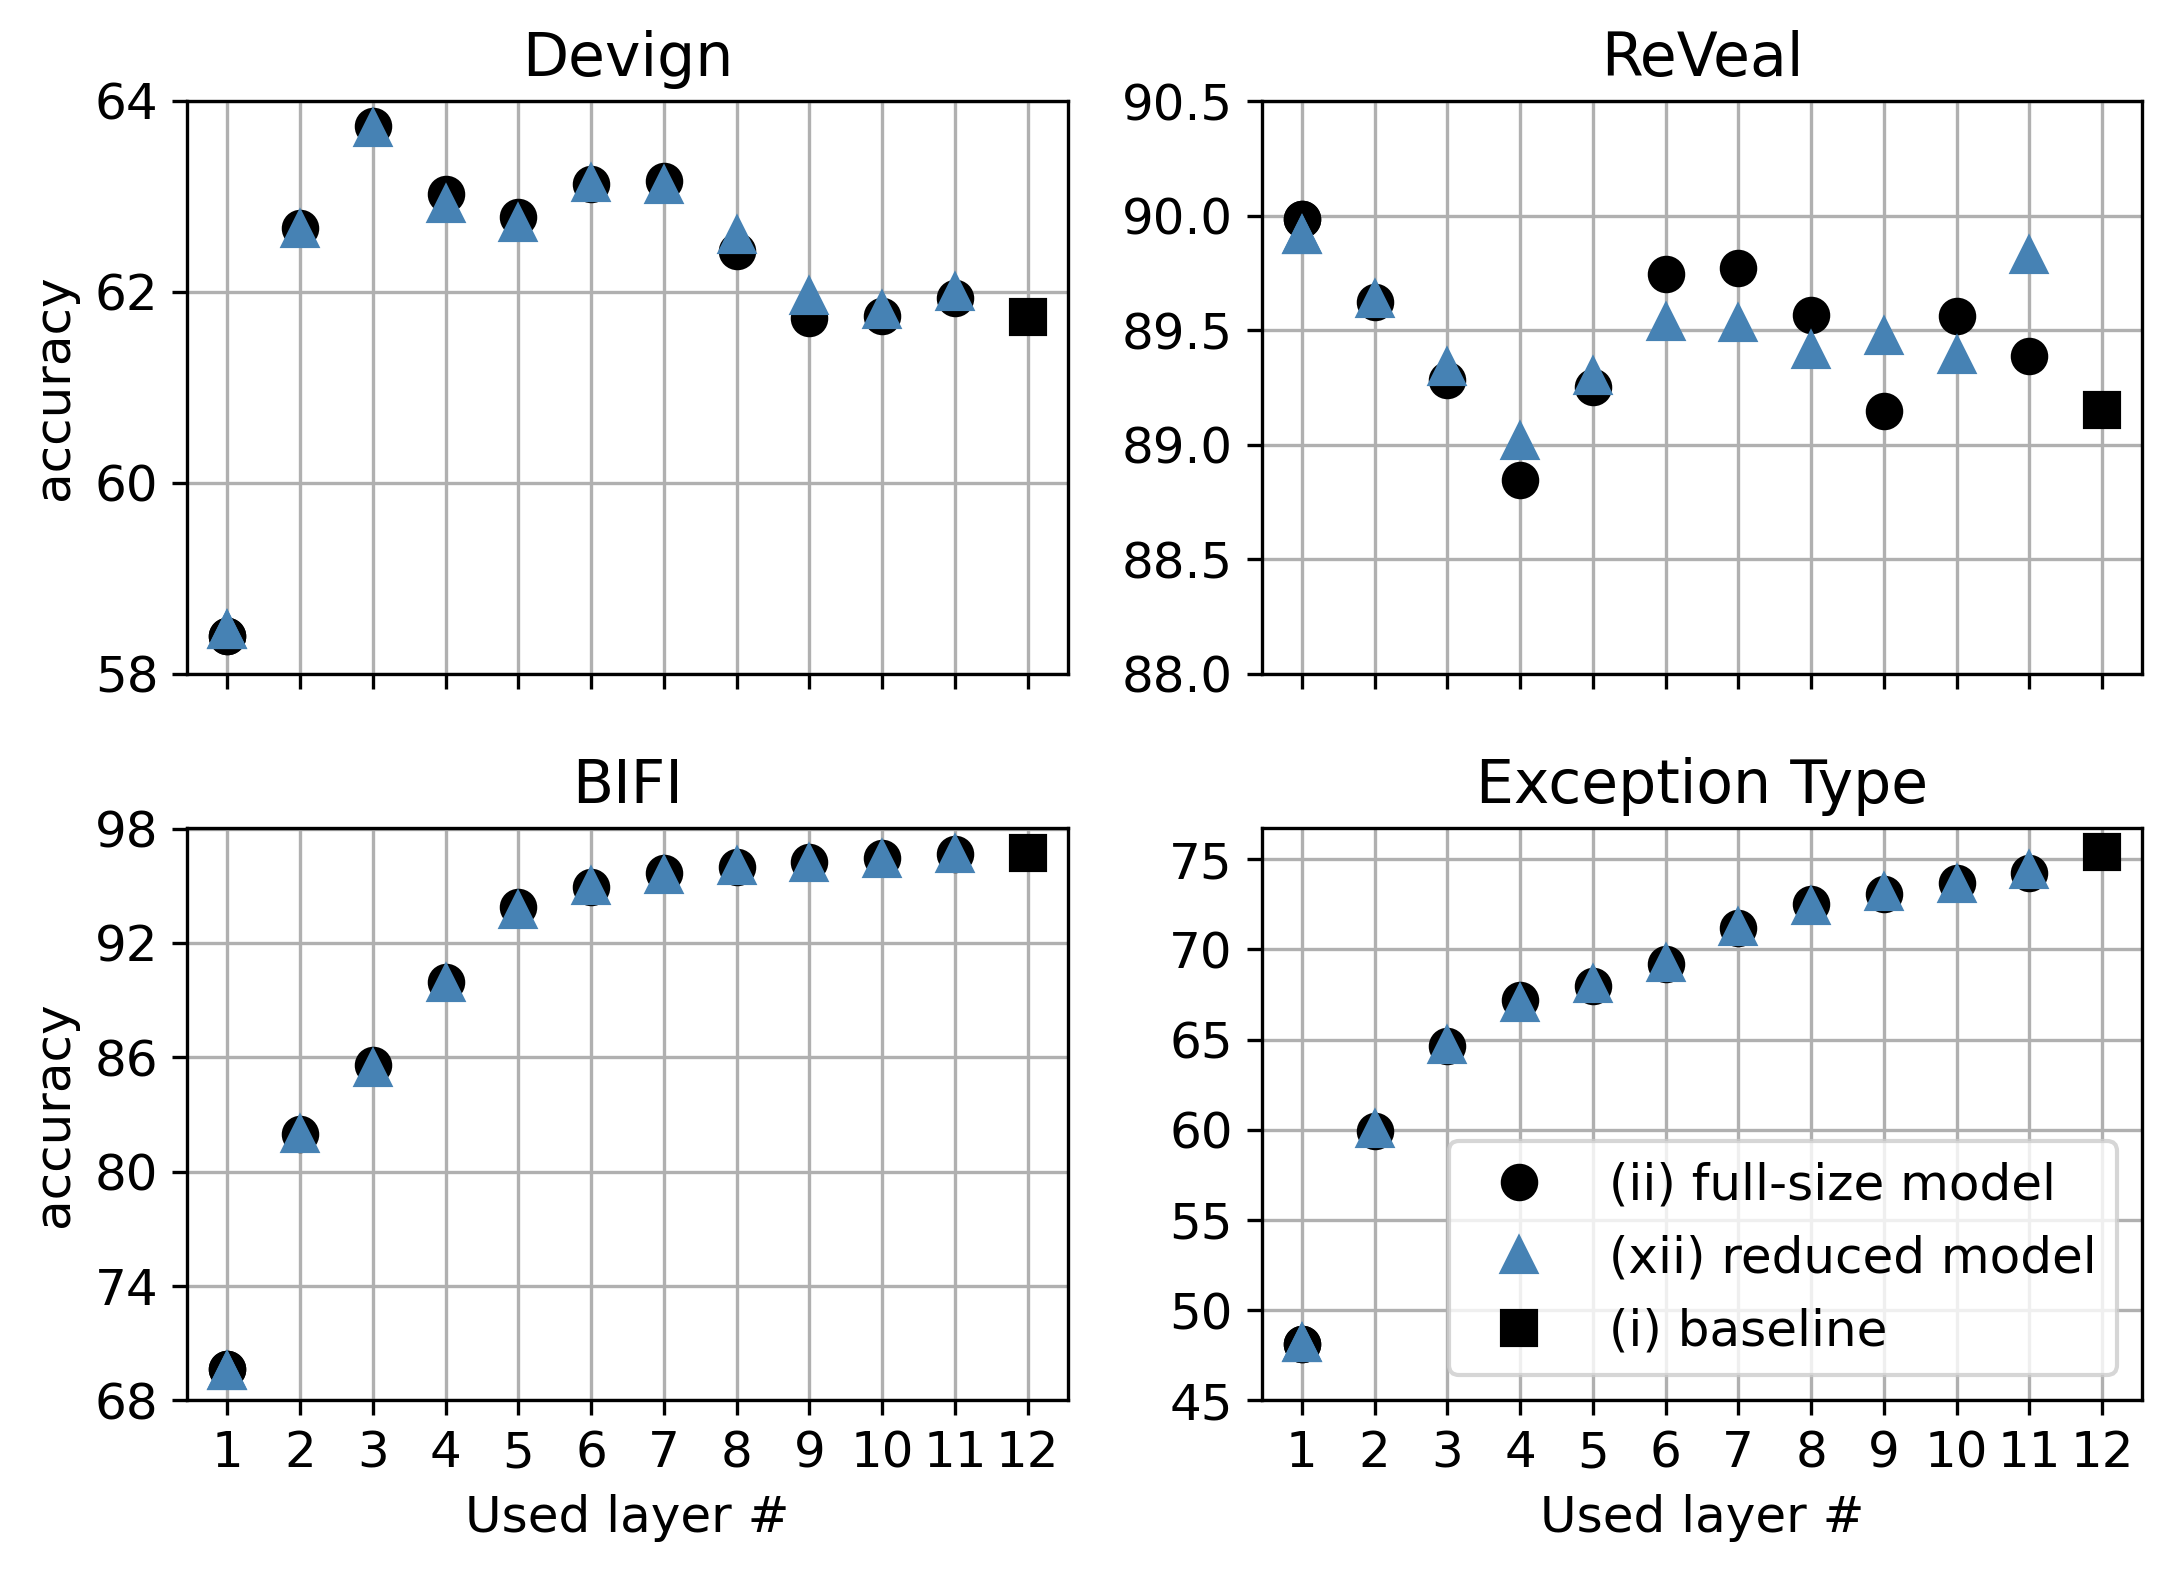

In [19]:
output_dir = plot_dir / 'cls_combinations'
if not output_dir.exists():
    output_dir.mkdir(parents=True, exist_ok=True)

matplotlib.rcParams.update({'font.size': 12})
layer_baseline = 12
c_baseline = 'one_layer_cls'
c = 'one_layer_cls'

cyan = 'steelblue'

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7.4, 5.4), dpi=300)
for name, x, y in zip(experiment_names, [0, 0, 1, 1], [0, 1, 0, 1]):
    vmin = +100
    vmax = -100
    
    metric = 'acc_test'
    
    for c, marker, label, color in zip(['one_layer_cls', 'cutoff_layers_one_layer_cls'], ['o', '^'], ['(ii) full-size model', '(xii) reduced model'], ['k', cyan]):
        for layer in range(1, 12):
            value = np.mean(list(map(lambda x: x*100, get_values(table, name, layer, default_sp_tokens_to_zero, c, f'metrics.{metric}'))))
            vmin = min(vmin, value)
            vmax = max(vmax, value)

            axs[x, y].plot(layer, value, ls='', marker=marker, ms=8, c=color)
            if layer == 1:
                axs[x, y].plot(layer, value, ls='', marker=marker, ms=8, c=color, label=label)
        
    baseline_values = get_values(table, name, layer_baseline, default_sp_tokens_to_zero, c_baseline, f'metrics.{metric}')
    # save baseline values to df
    baseline_mean = np.mean(list(map(lambda x: x*100, baseline_values)))

    axs[x, y].plot(layer_baseline, baseline_mean, ls='', marker='s', ms=8, c='k', label='(i) baseline')
    axs[x, y].grid()
    axs[x, y].set_xticks(list(range(1,13)), [])
    
    if name == 'devign':
        # f1 w
        ymin = 57
        ymax = 65
        
        # acc
        ymin = 58
        ymax = 64
        axs[x, y].set_yticks(np.arange(round(ymin, 0), round(ymax, 1)+1, 2))
        axs[x, y].set_ylim((ymin, ymax))
        
        
    elif name == 'reveal':
        # f1 w
        ymin = 87
        ymax = 89.5
        step = 0.5
        
        # acc
        ymin = 88
        ymax = 90.5
        step = 0.5
        axs[x, y].set_yticks(np.arange(round(ymin, 0), round(ymax, 1)+1, step))
        axs[x, y].set_ylim((ymin, ymax))
        
    elif name == 'bifi':
        axs[x, y].set_yticks(range(68, 100, 6))
    elif name == 'exception':
        axs[x, y].set_yticks(range(45, 80, 5))
        axs[x, y].legend(loc='lower right')
        
    axs[x, y].set_title(f'{plot_experiment_names[name]}')
    
axs[0, 0].set_ylabel(plot_metric_names[metric])
axs[1, 0].set_ylabel(plot_metric_names[metric])

axs[1, 0].set_xticks(list(range(1,13)), labels=list(range(1,13)))
axs[1, 0].set_xlabel('Used layer #')
axs[1, 1].set_xticks(list(range(1,13)), labels=list(range(1,13)))
axs[1, 1].set_xlabel('Used layer #')
fig.tight_layout()
                   
filepath = output_dir / f'cls_one_layer_means_{metric}_performance.pdf'
plt.savefig(filepath, bbox_inches='tight')

plt.show()


# One layer combinatiions

## Table: compute mean of performance (metric) differences for plots

In [20]:
output_dir = plot_dir / 'heatmap_all_combinations'
if not output_dir.exists():
    output_dir.mkdir(parents=True, exist_ok=True)

matplotlib.rcParams.update({'font.size': 8})

c_baseline = 'one_layer_cls'
l_baseline = 12

sp_tokens  = False
dfs = {}
dfs_one_layer = {}
dfs_one_layer_pvalues = {}

for name in experiment_names:
    dfs_one_layer[name] = {}
    dfs_one_layer_pvalues[name] = {}

for metric in ['acc_test', 'f1_weighted_test']:
    for func, func_name in zip([np.max, np.mean], ['max', 'mean']):
        for name in experiment_names:

            dfs_one_layer[name][metric] = pd.DataFrame(index=[c for c in combinations if 'one_layer' in c and not 'cutoff' in c] + \
                                                               ['one_layer_w_sum_tokens' + sp_tokens_suffix, 'one_layer_max_pool_tokens' + sp_tokens_suffix], 
                                             columns=single_layers, data=np.nan)

            dfs_one_layer_pvalues[name][metric] = dfs_one_layer[name][metric].copy()

            baseline_values = []
            for seed in seeds:
                baseline_values.append(
                    table[name].loc[(table[name].loc[:, 'params.combination_type'] == c_baseline) & \
                                    (table[name].loc[:, 'params.hidden_layer_to_use'] == 12) & \
                                    (table[name].loc[:, 'params.epochs'] == 10) & \
                                    (table[name].loc[:, 'params.not_special_tokens_to_zero'] == default_sp_tokens_to_zero) & \
                                    (table[name].loc[:, 'params.seed'] == seed), 
                                    f'metrics.{metric}'].values.tolist()[0])
            baseline_metric_mean = func(baseline_values)

            c_names = [c for c in combinations if 'one_layer' in c and not 'cutoff' in c]

            for c in c_names:
                if 'one_layer' in c:
                    layers = single_layers
                else:
                    layers = [12]

                sp_tokens_choice = [False] if 'cls' in c else [True, False]

                for sp_tokens in sp_tokens_choice:
                    row = c + sp_tokens_suffix if not sp_tokens and not 'cls' in c else c
                    for l in layers:
                        combination_values = get_values(table, name, l, sp_tokens, c, f'metrics.{metric}')
                        combination_values_mean = func(combination_values)
                        dfs_one_layer[name][metric].loc[row, l] = (combination_values_mean - baseline_metric_mean) * 100

                        stat = wilcoxon(combination_values, baseline_values)
                        dfs_one_layer_pvalues[name][metric].loc[row, l] = stat.pvalue

            print(f'{name} {metric} {func_name} {baseline_metric_mean}')

            # max improvement
            max_improvement = dfs_one_layer[name][metric].max().max()
            row_max = [r for r in dfs_one_layer[name][metric].index if max_improvement == dfs_one_layer[name][metric].loc[r, :].max()]
            col_max = [r for r in dfs_one_layer[name][metric].columns if max_improvement == dfs_one_layer[name][metric].loc[:, r].max()]

            # save differences
            # dfs_one_layer[name][metric].to_excel(table_dir / f'{name}_{plot_metric_names[metric]}_variance_of_{func_name}.xlsx')
            # dfs_one_layer_pvalues[name][metric].to_excel(table_dir / f'{name}_{plot_metric_names[metric]}_pvalues_for_variance_of_{func_name}.xlsx')

devign acc_test max 0.6346998535871157
reveal acc_test max 0.907651715039578
bifi acc_test max 0.9693125207572236
exception acc_test max 0.7691341321994588
devign acc_test mean 0.6173865300146413
reveal acc_test mean 0.8915127528583995
bifi acc_test mean 0.9670009963467286
exception acc_test mean 0.7539427908774642
devign f1_weighted_test max 0.6330165297183509
reveal f1_weighted_test max 0.8920717448743095
bifi f1_weighted_test max 0.969309180352228
exception f1_weighted_test max 0.7675580653839469
devign f1_weighted_test mean 0.6040094266899342
reveal f1_weighted_test mean 0.88533908654633
bifi f1_weighted_test mean 0.9670115256608176
exception f1_weighted_test mean 0.7529717182391295


## \# params in w sum combinations vs baseline
Note: combinations of layers with weighted sums have the largest number 
of added parameters. We aim to compute the percentage of the number 
of added parameters out of the number of parameters in the baseline model.


In [21]:
combinations

['cutoff_layers_one_layer_cls',
 'one_layer_cls',
 'max_pool_cls',
 'w_sum_cls',
 'one_layer_max_pool_tokens',
 'max_pool_layers_max_pool_tokens',
 'max_pool_layers_w_sum_tokens',
 'max_pool_tokens_w_sum_layers',
 'one_layer_w_sum_tokens',
 'w_sum_tokens_w_sum_layers',
 'w_sum_layers_w_sum_tokens']

In [22]:
for name in experiment_names:

    baseline_values = []
    for seed in seeds:
        baseline_values.append(
            table[name].loc[(table[name].loc[:, 'params.combination_type'] == c_baseline) & \
                            (table[name].loc[:, 'params.hidden_layer_to_use'] == 12) & \
                            (table[name].loc[:, 'params.epochs'] == 10) & \
                            (table[name].loc[:, 'params.not_special_tokens_to_zero'] == default_sp_tokens_to_zero) & \
                            (table[name].loc[:, 'params.seed'] == seed), 
                            f'params.num_trainable_parameters'].values.tolist()[0])
    for c, l in zip(['w_sum_tokens_w_sum_layers', 'one_layer_w_sum_tokens'], [12, 2]):
        w_sum_values = get_values(table, name, 12, sp_tokens, c, f'params.num_trainable_parameters')
        w_sum_mean_params = np.mean(w_sum_values)
        baseline_mean_params = np.mean(baseline_values)
        diff = (w_sum_mean_params - baseline_mean_params)/baseline_mean_params*100.
        print(f'{name} l {l}: # params\n w sum \t\t {w_sum_mean_params}\nbaseline \t\t {baseline_mean_params}\ndiff (%): \t\t {diff}\n\n')

devign l 12: # params
 w sum 		 124647694.0
baseline 		 124647170.0
diff (%): 		 0.0004203866000327163


devign l 2: # params
 w sum 		 124647694.0
baseline 		 124647170.0
diff (%): 		 0.0004203866000327163


reveal l 12: # params
 w sum 		 124647694.0
baseline 		 124647170.0
diff (%): 		 0.0004203866000327163


reveal l 2: # params
 w sum 		 124647694.0
baseline 		 124647170.0
diff (%): 		 0.0004203866000327163


bifi l 12: # params
 w sum 		 124648463.0
baseline 		 124647939.0
diff (%): 		 0.0004203840065097266


bifi l 2: # params
 w sum 		 124648463.0
baseline 		 124647939.0
diff (%): 		 0.0004203840065097266


exception l 12: # params
 w sum 		 124661536.0
baseline 		 124661012.0
diff (%): 		 0.0004203399215145149


exception l 2: # params
 w sum 		 124661536.0
baseline 		 124661012.0
diff (%): 		 0.0004203399215145149




## Figure - one-layer models

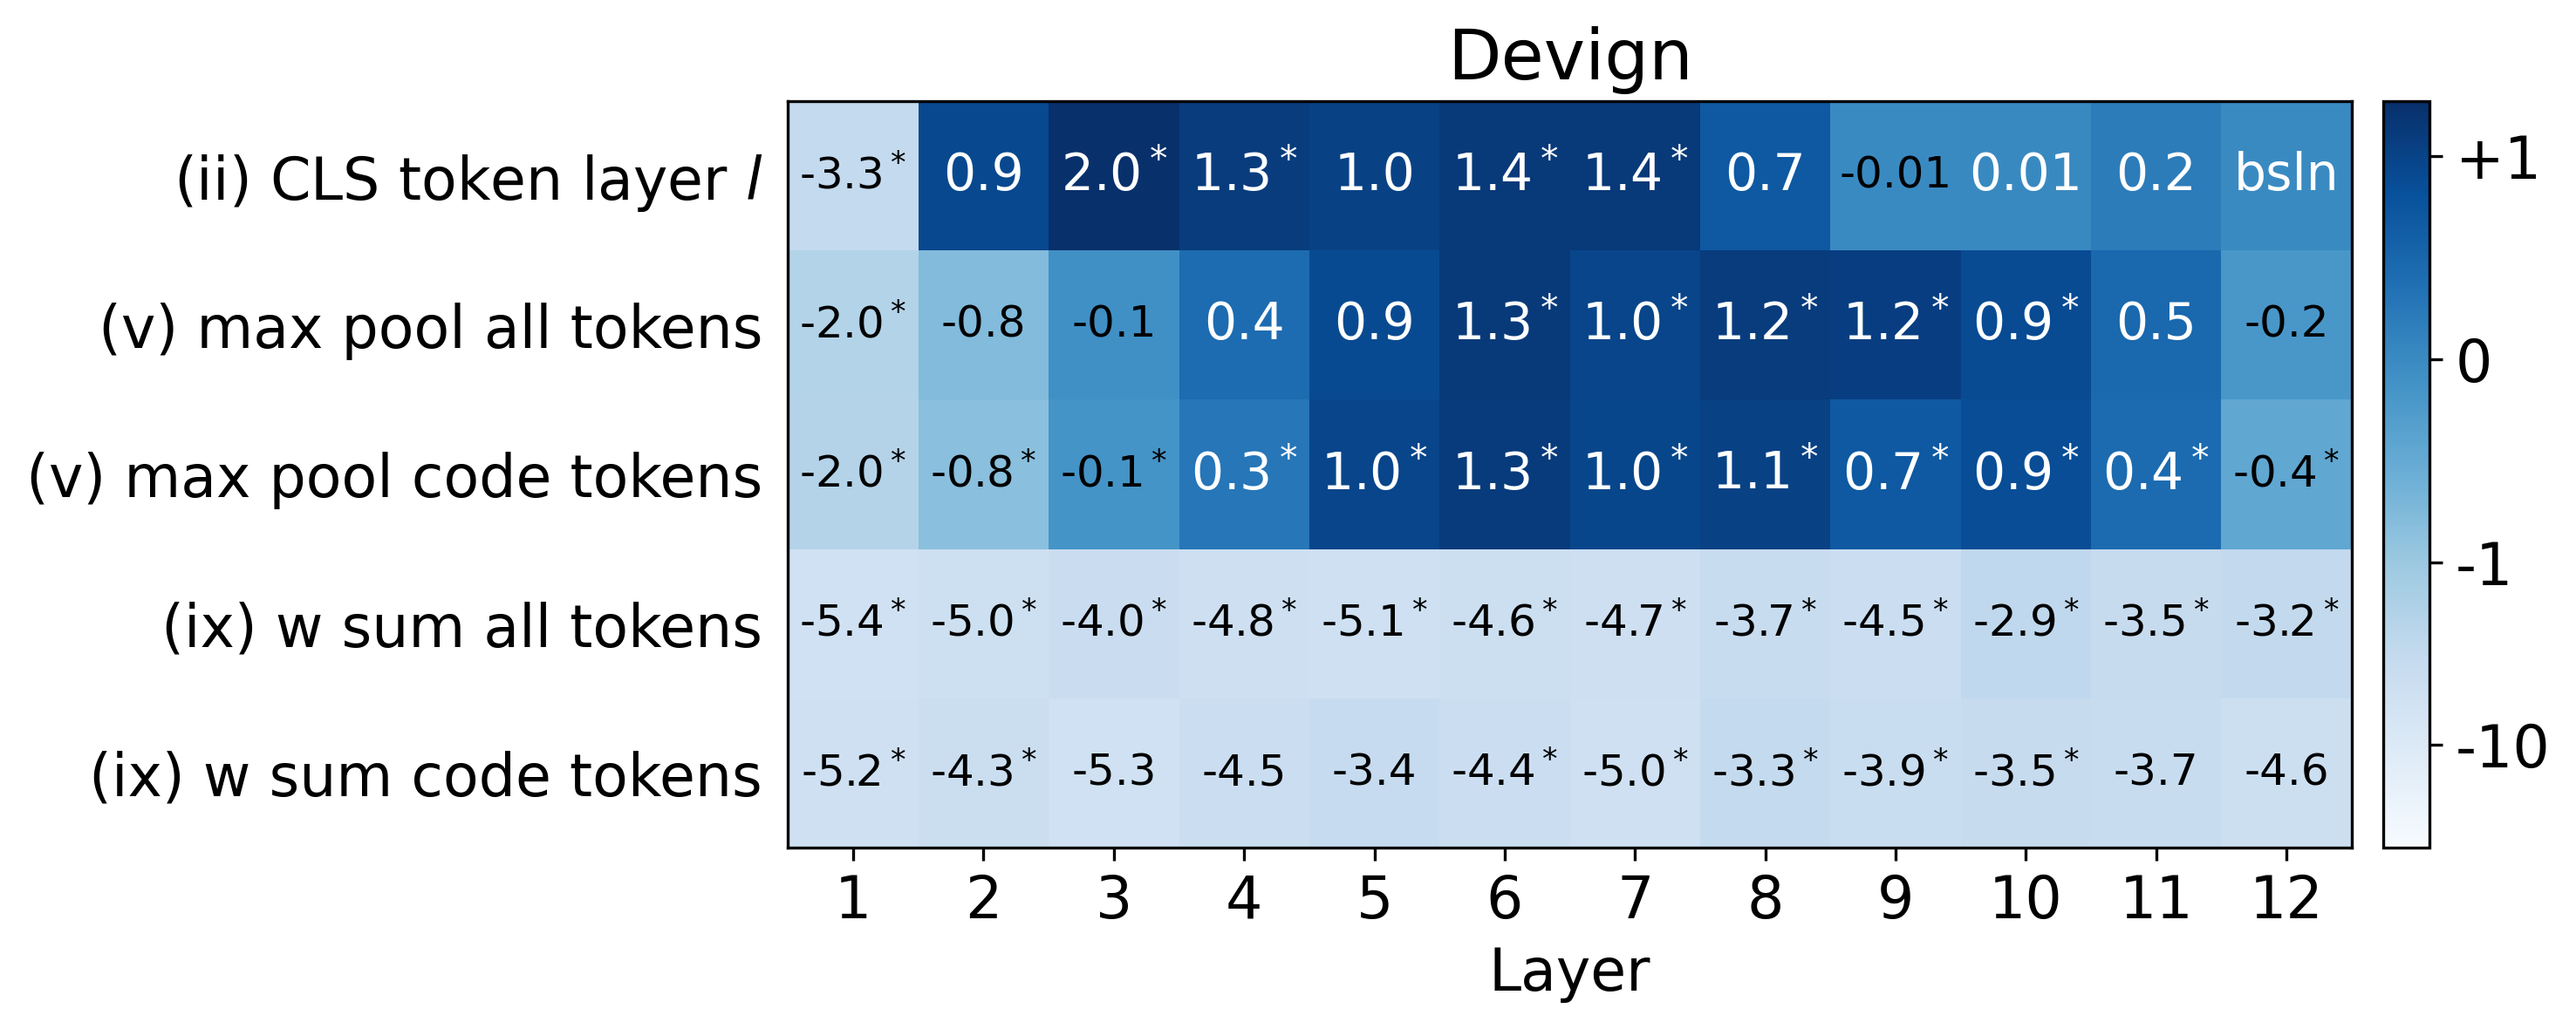

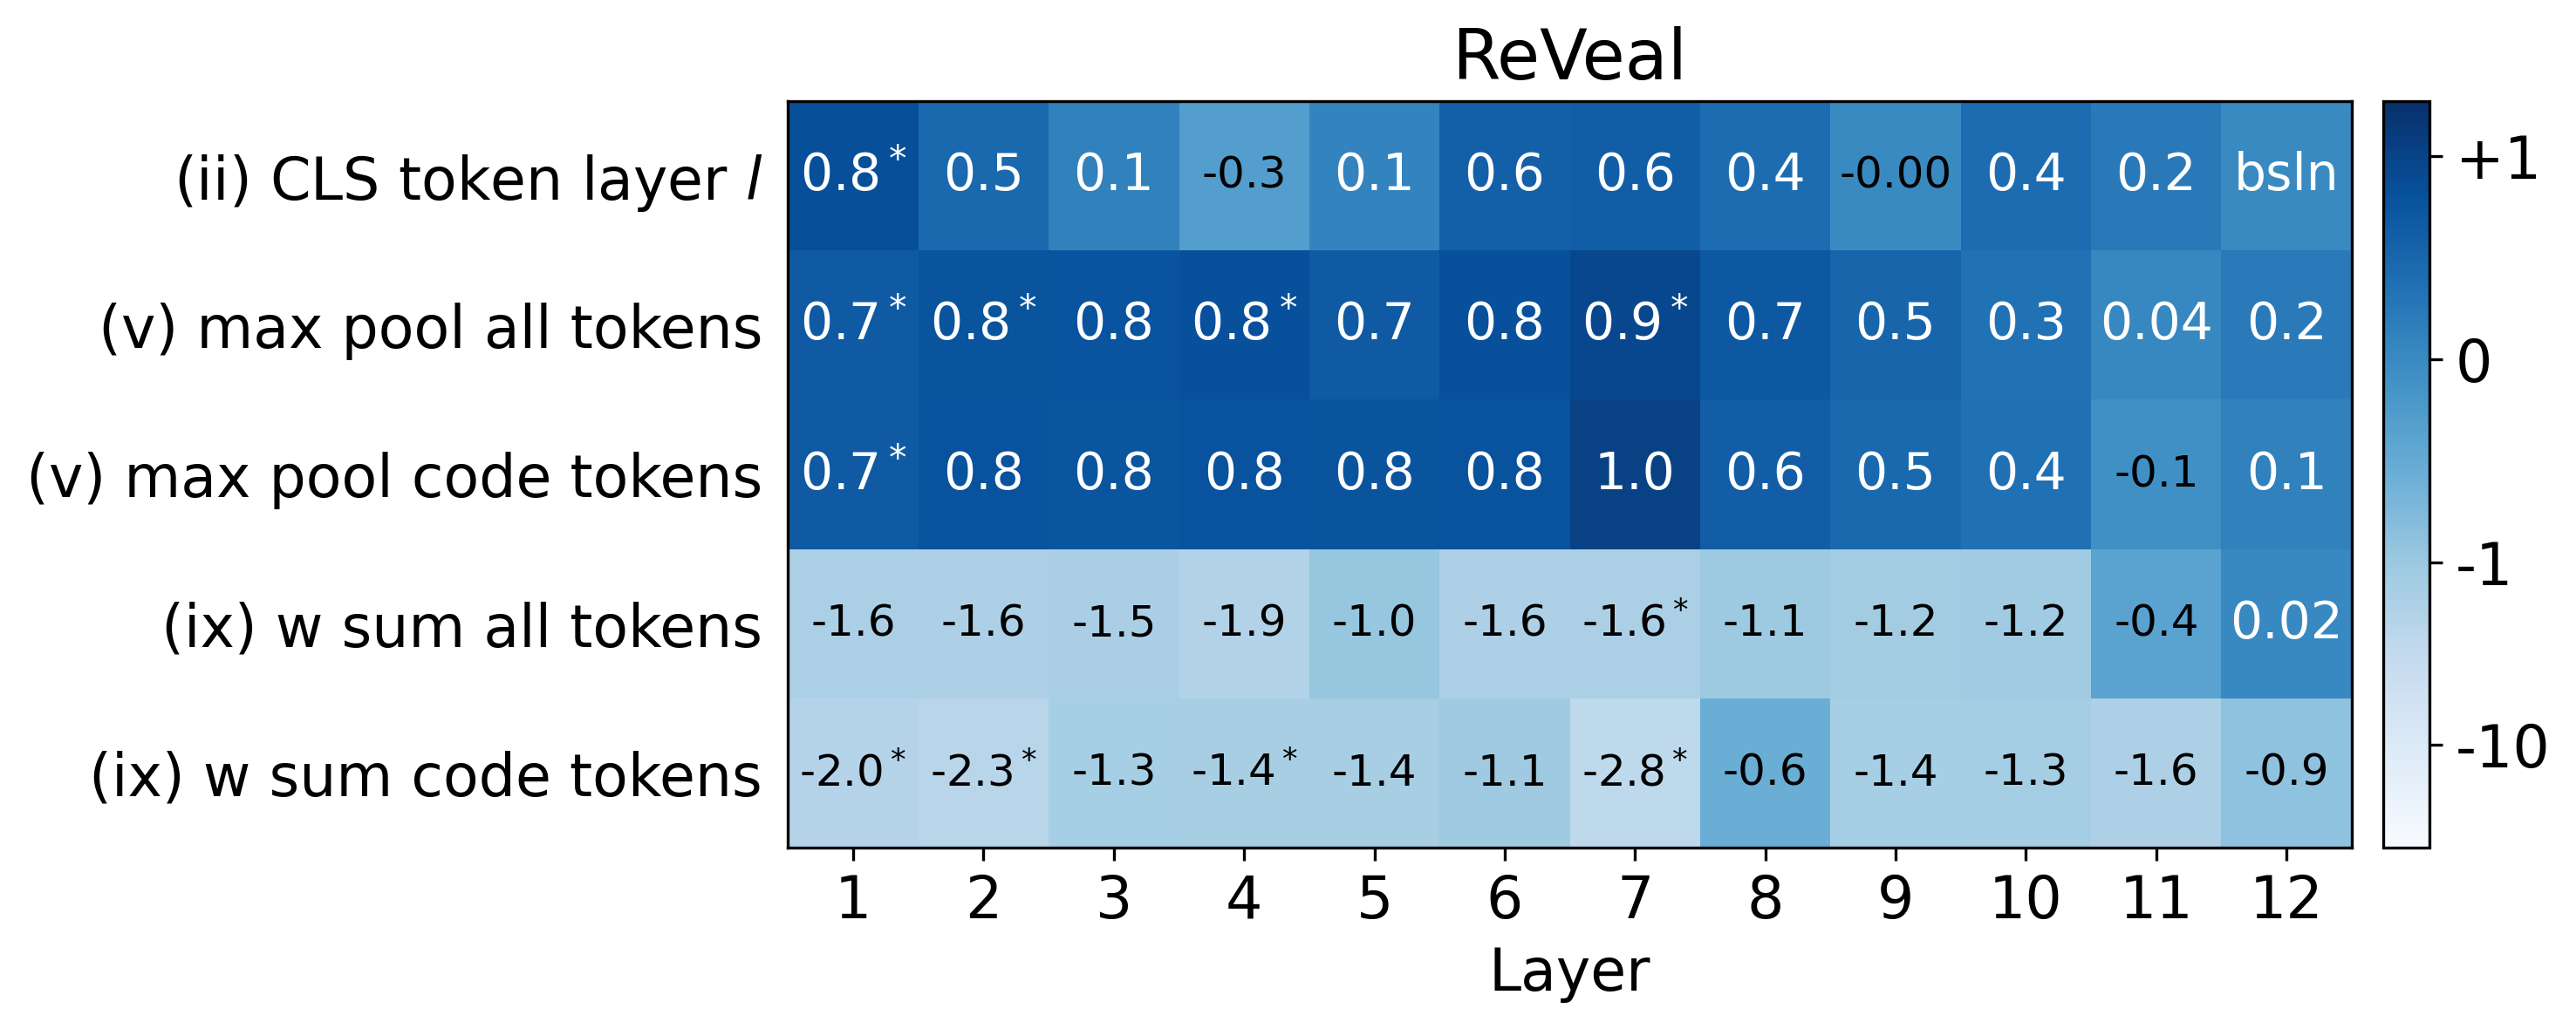

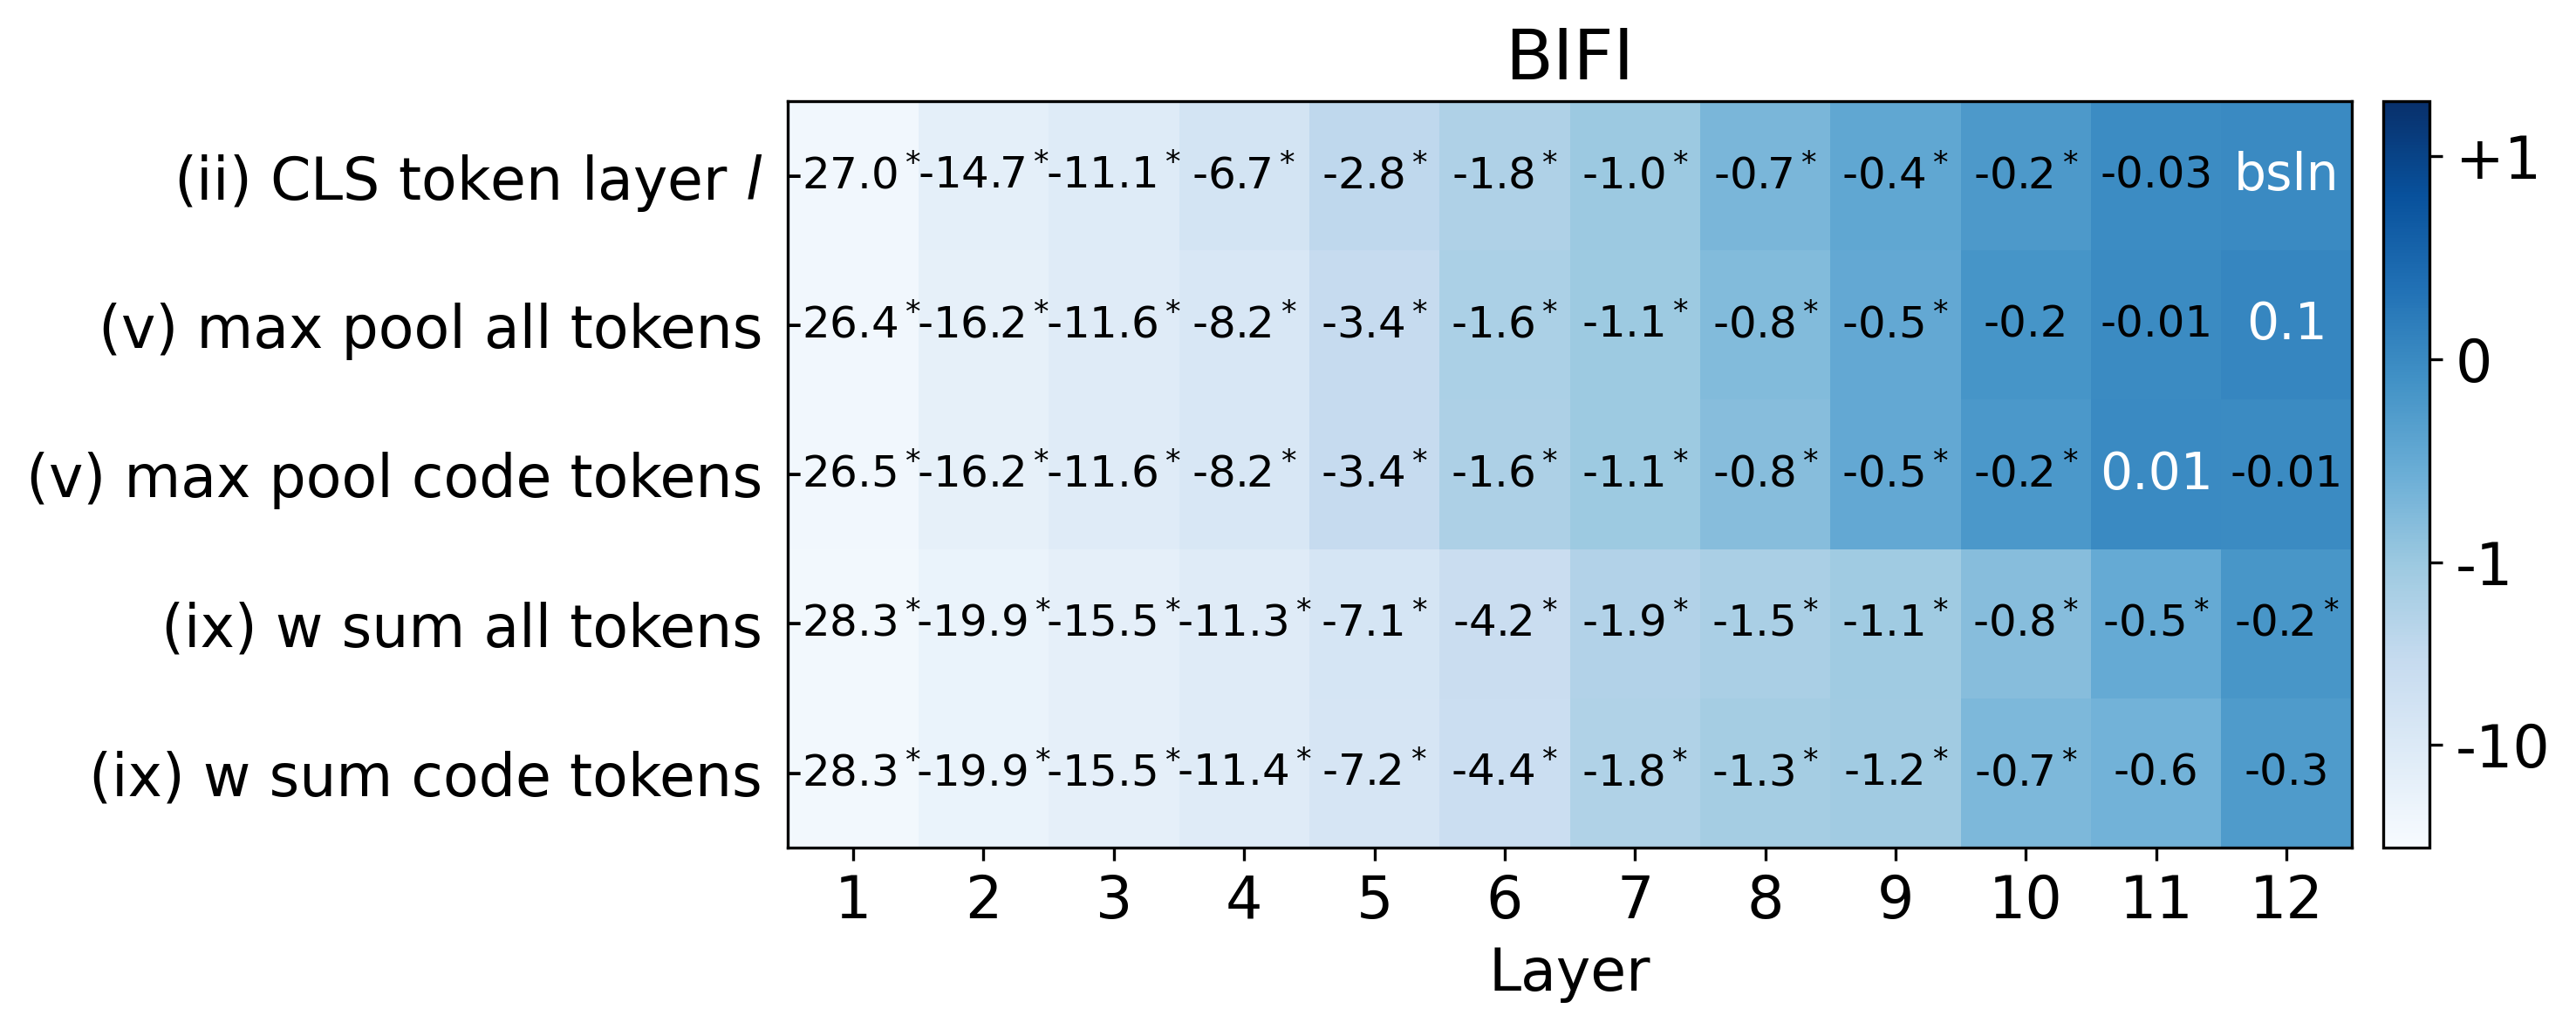

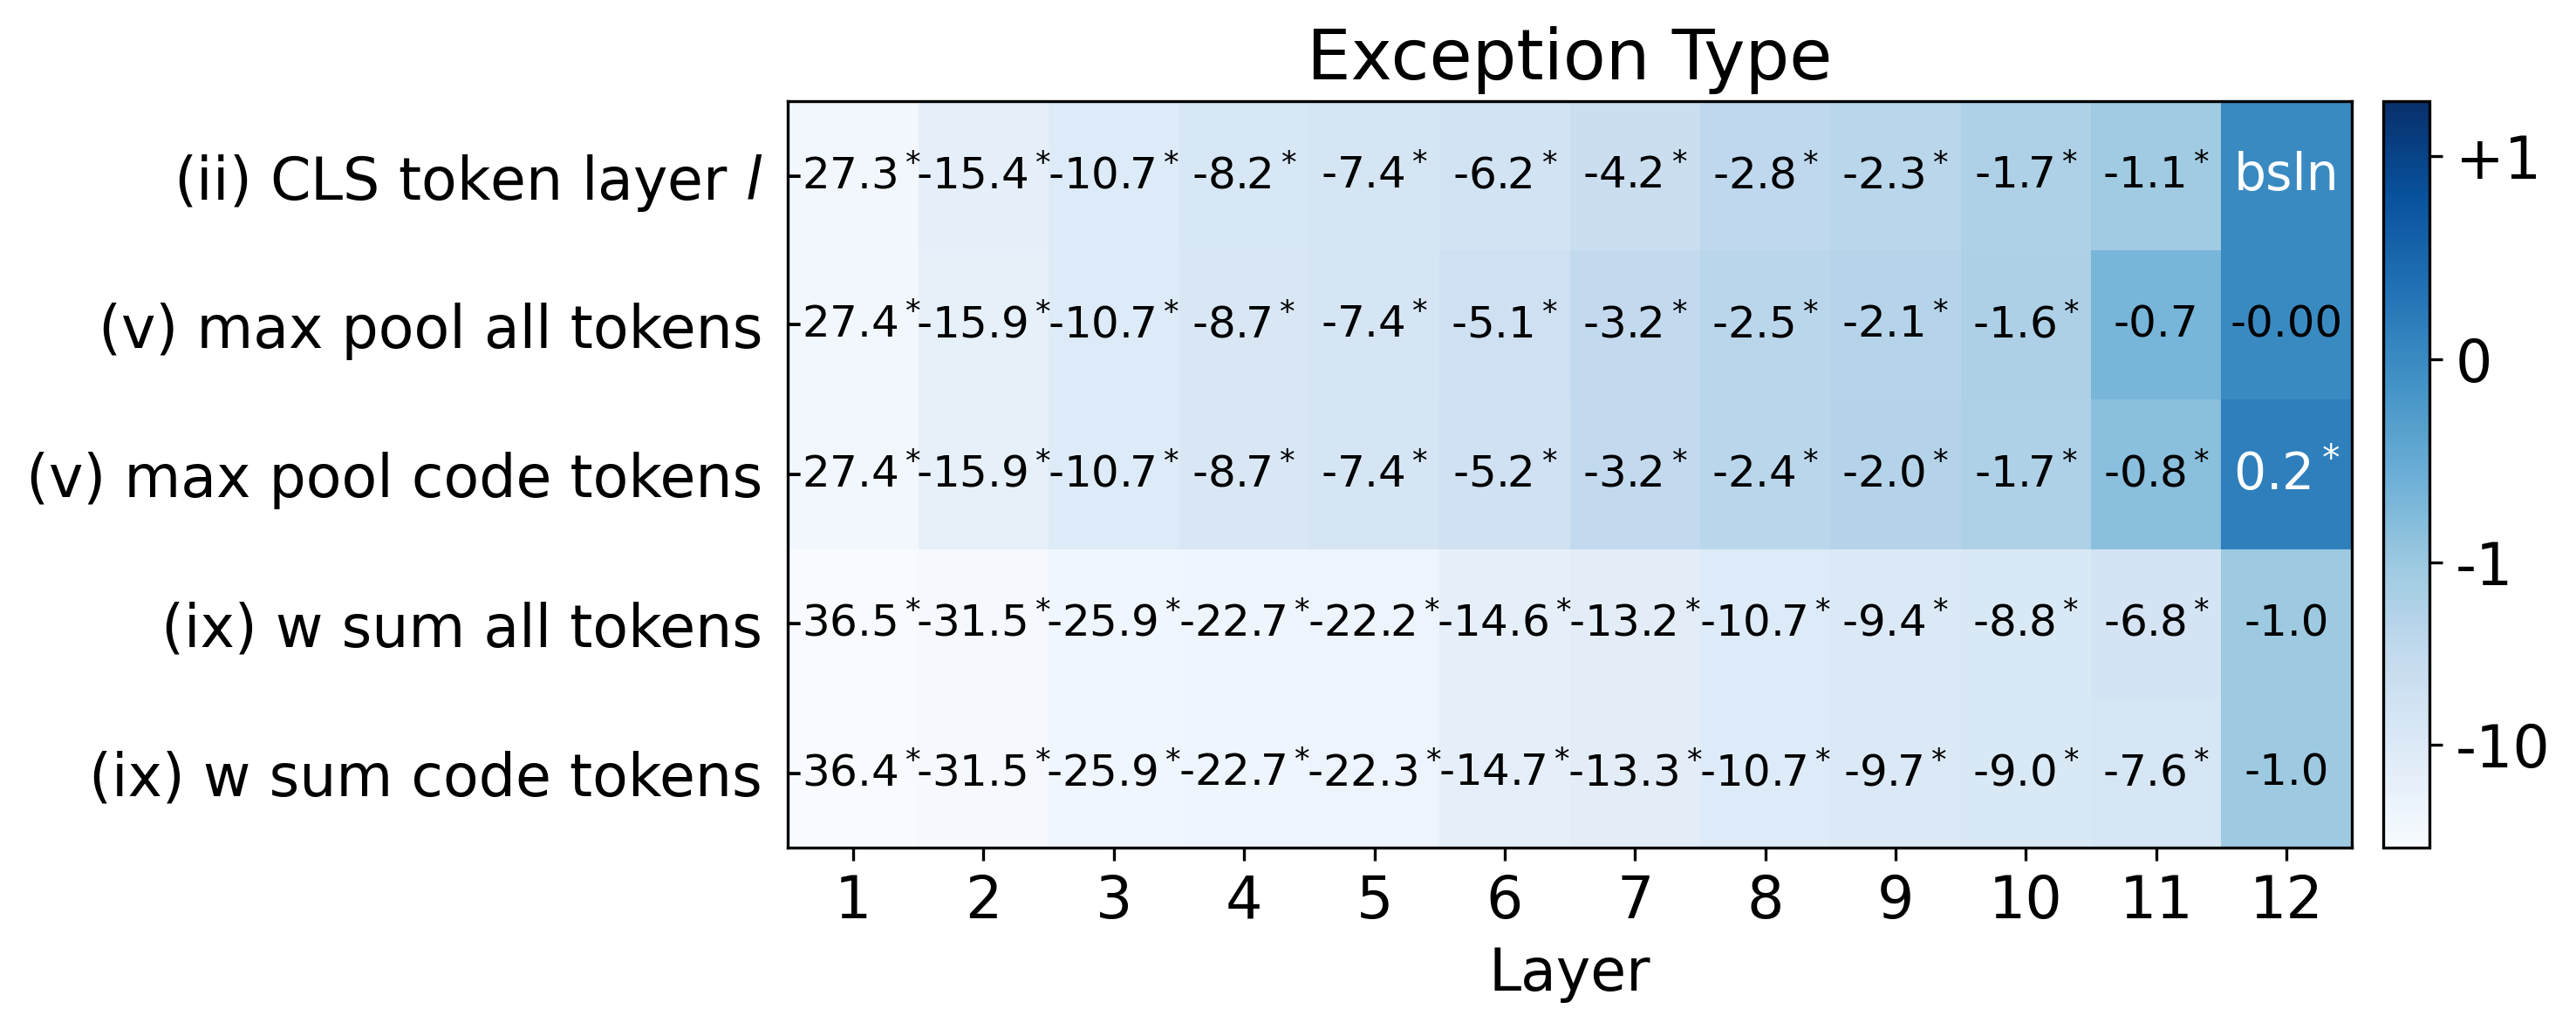

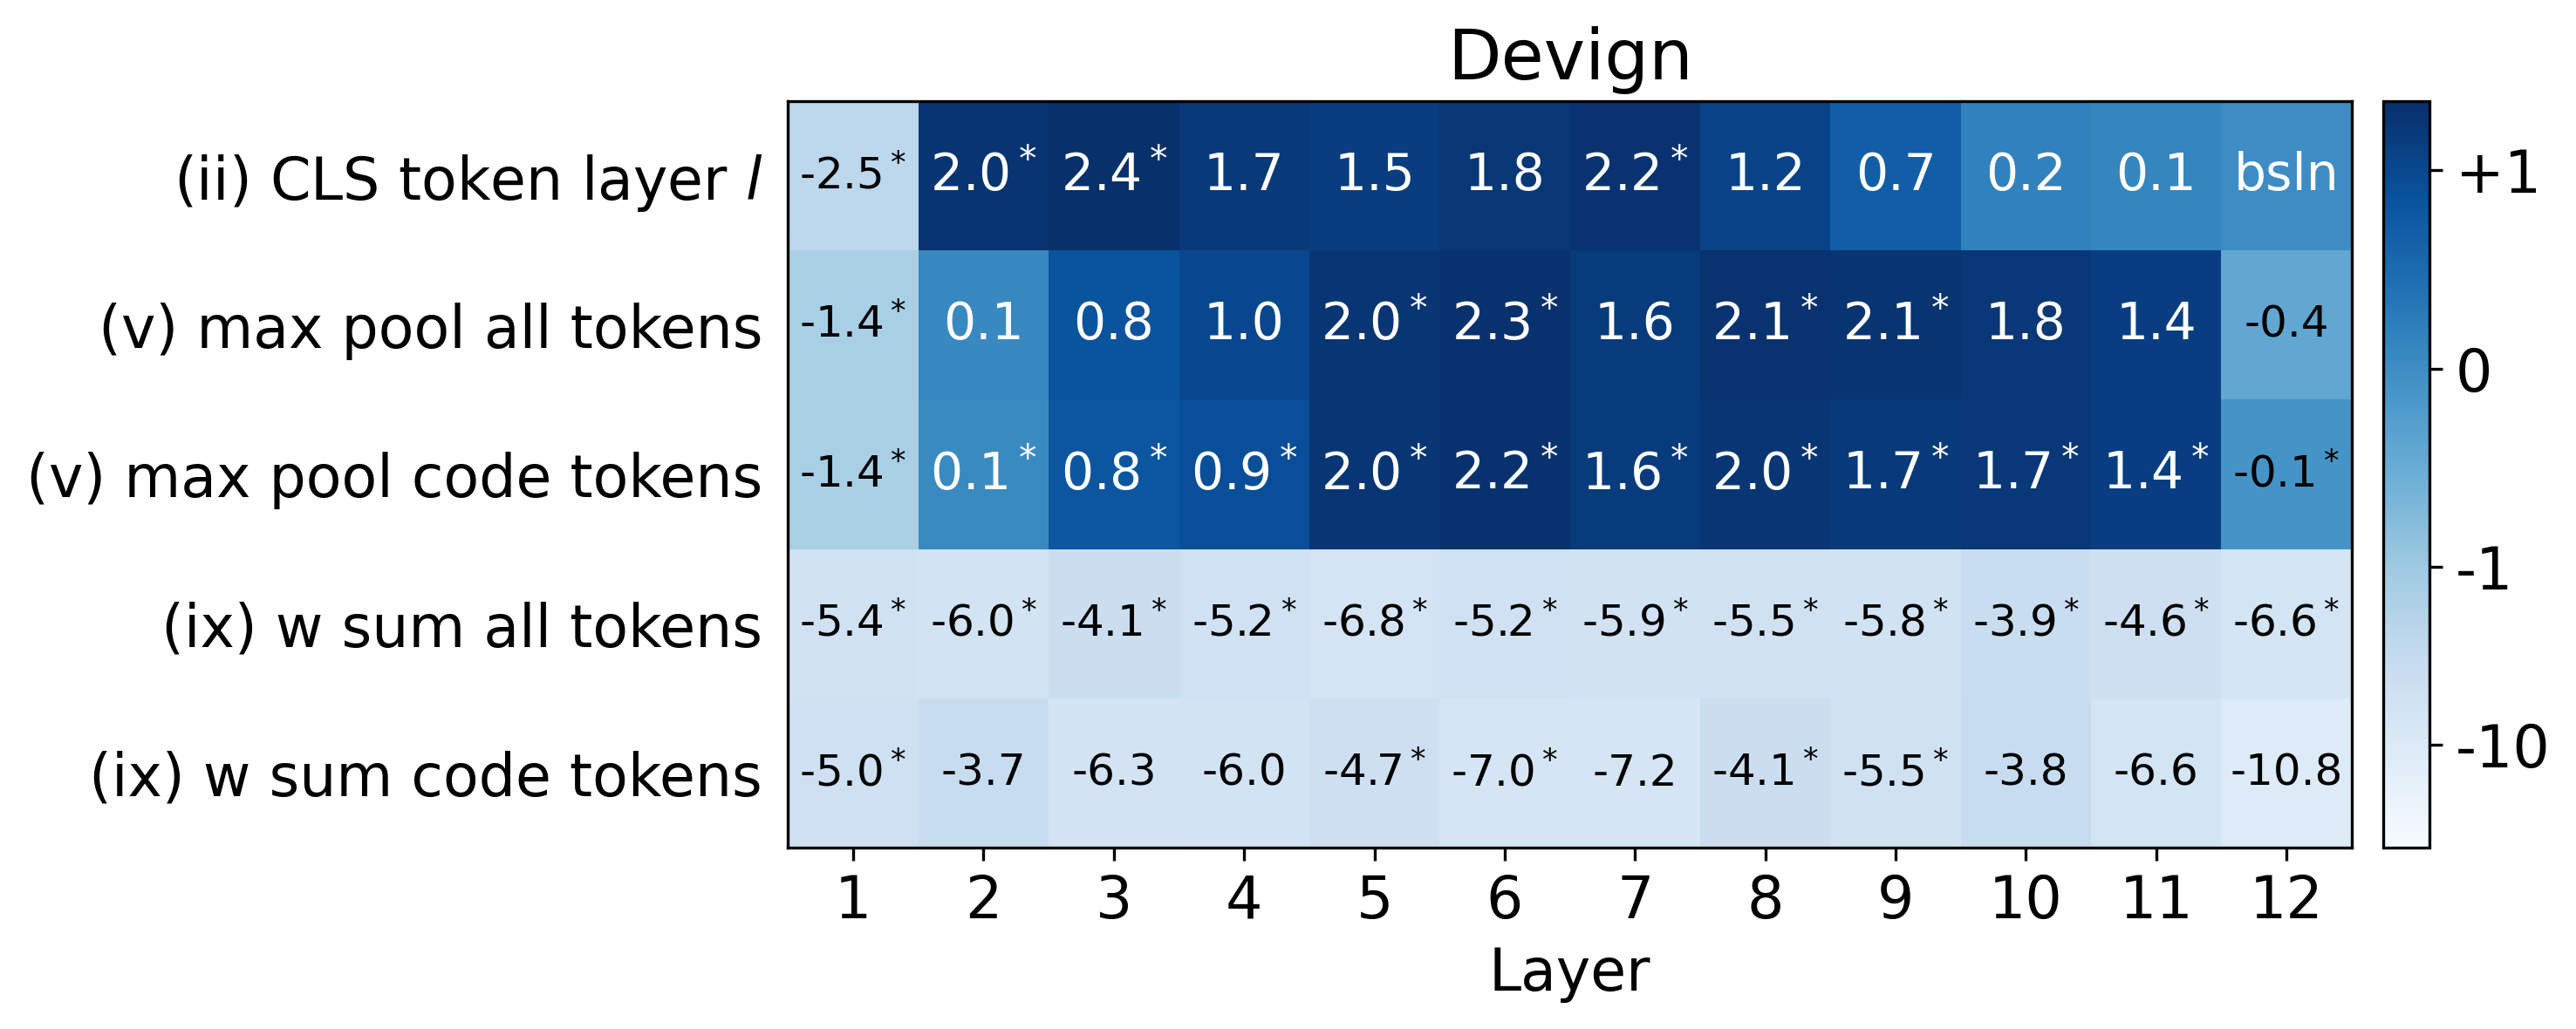

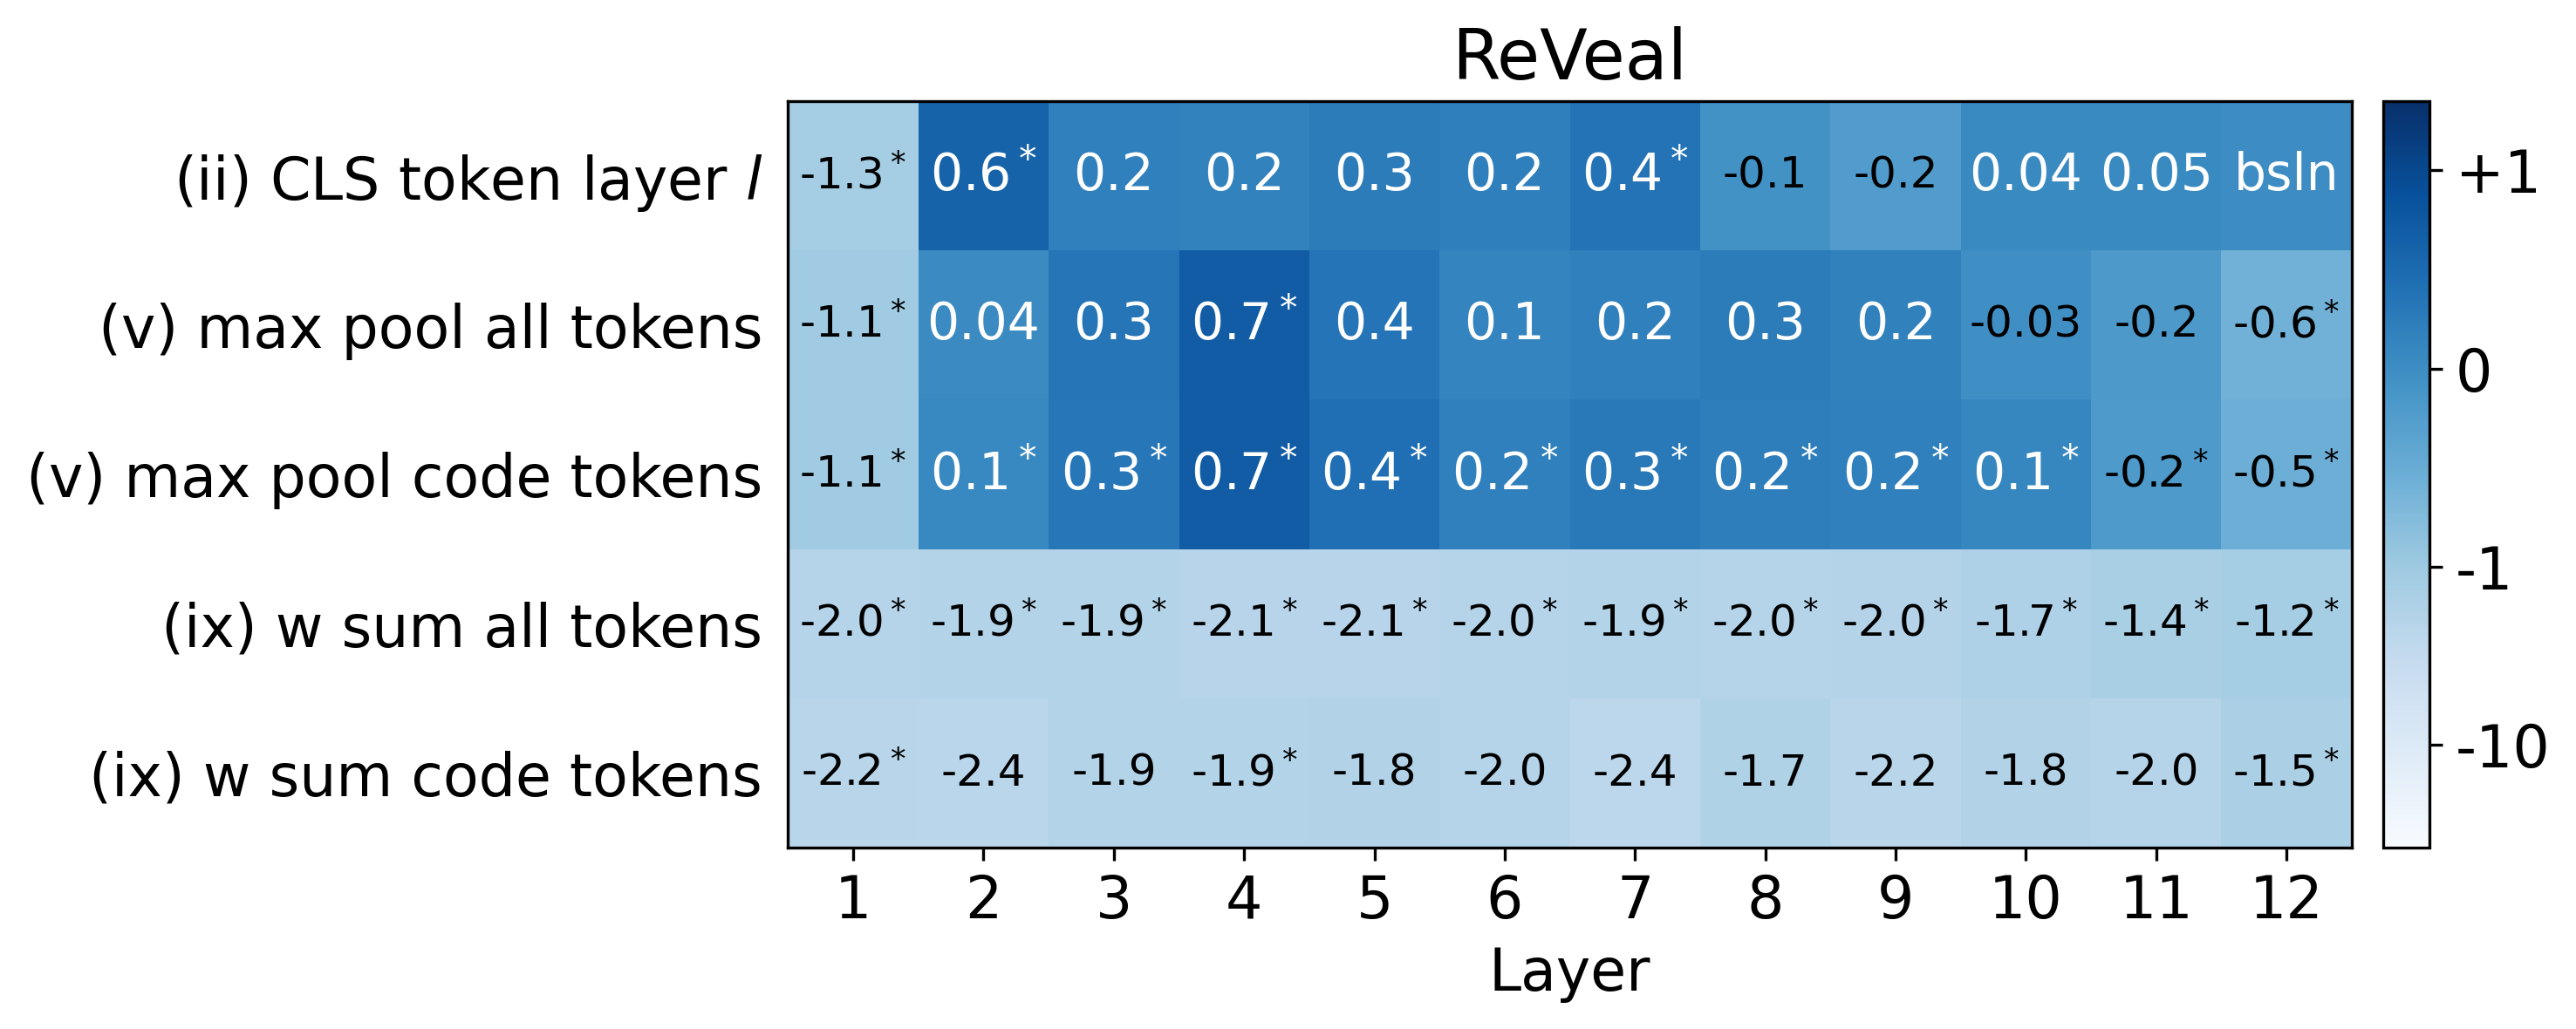

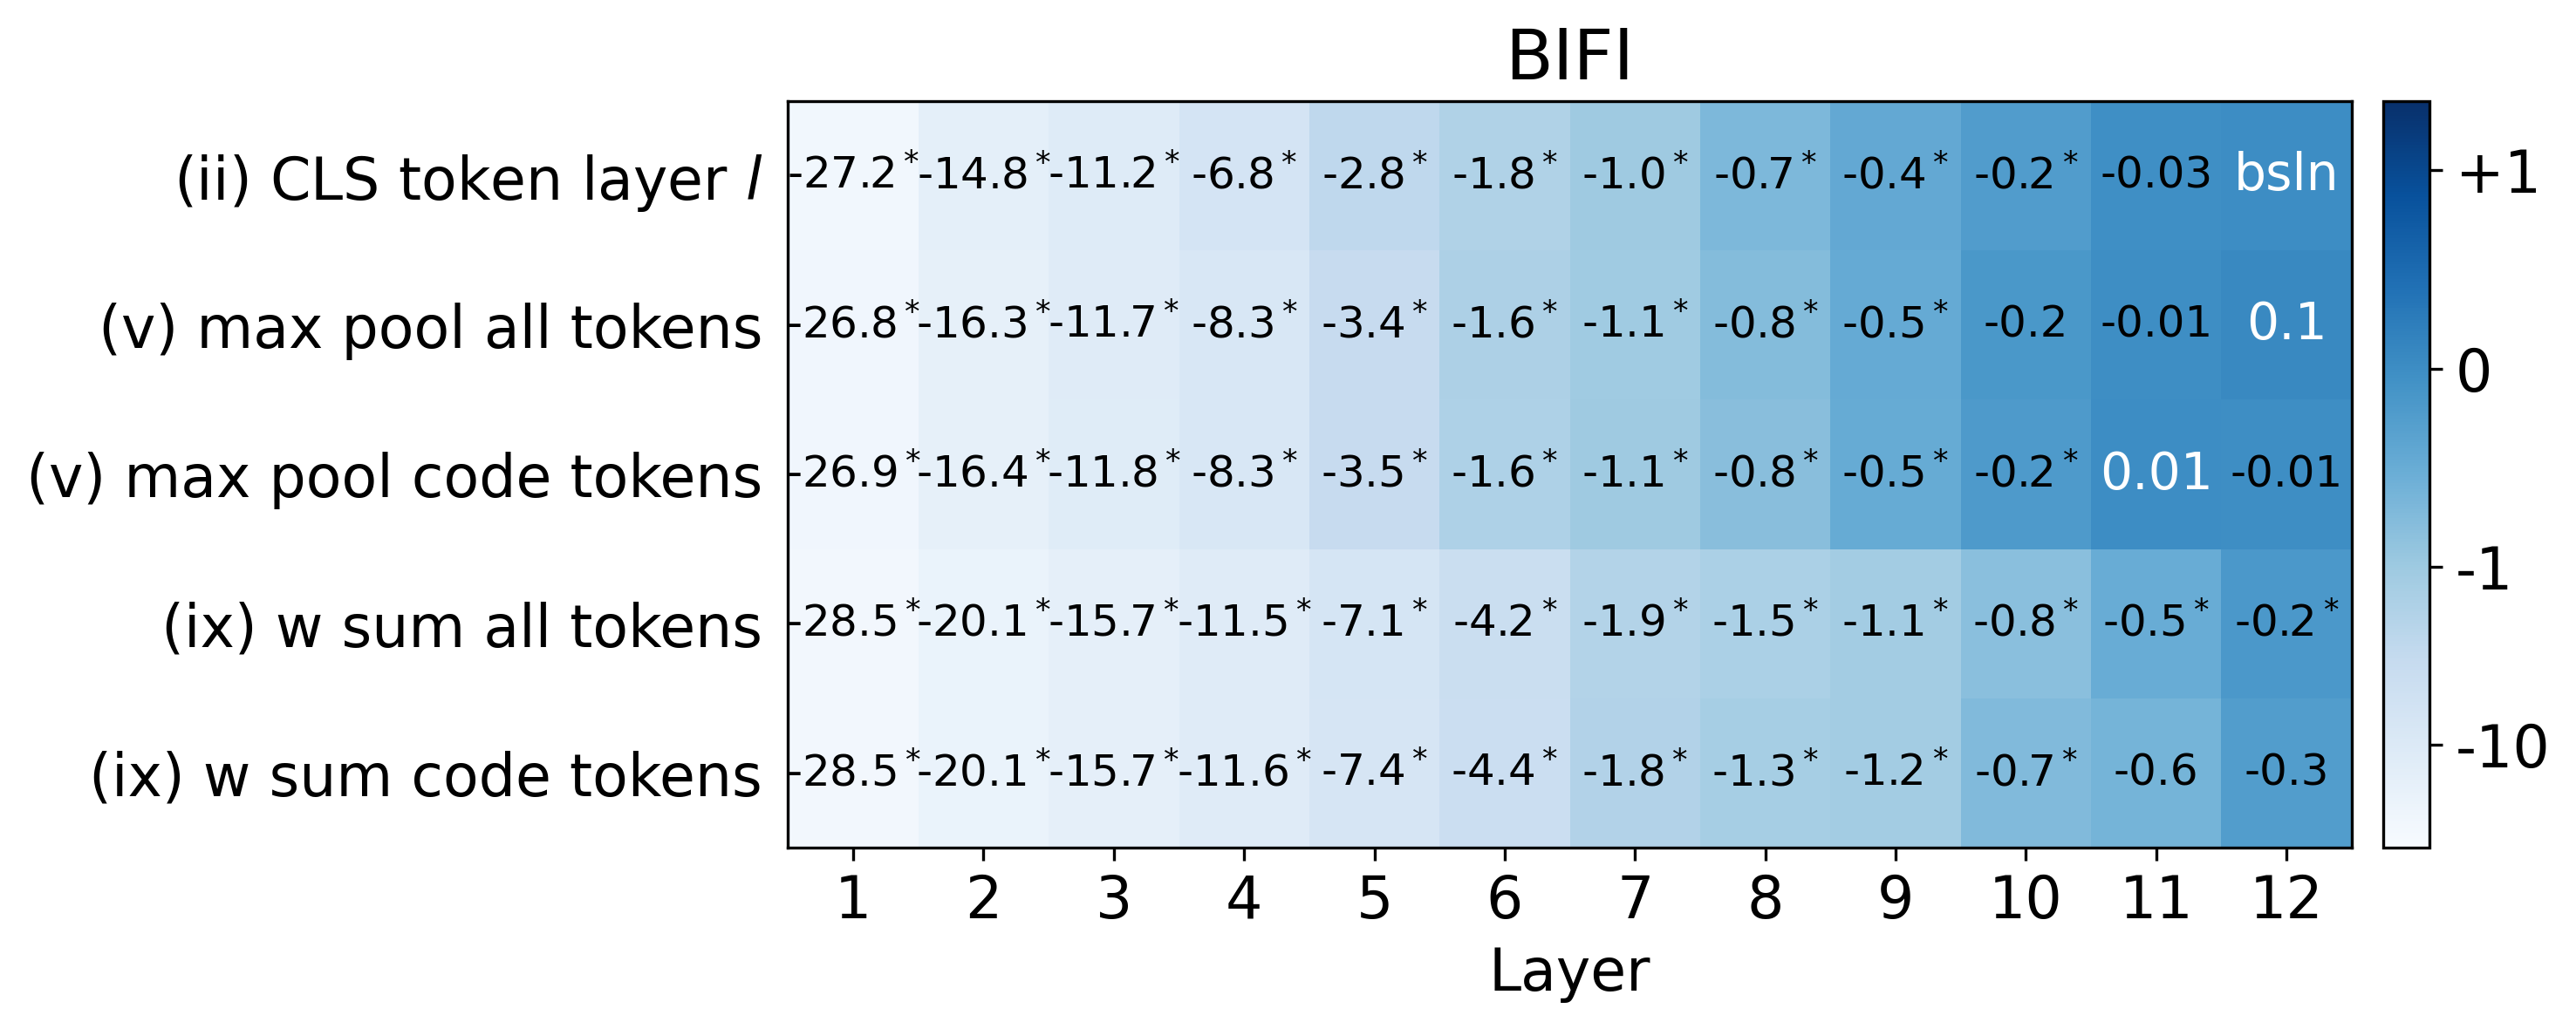

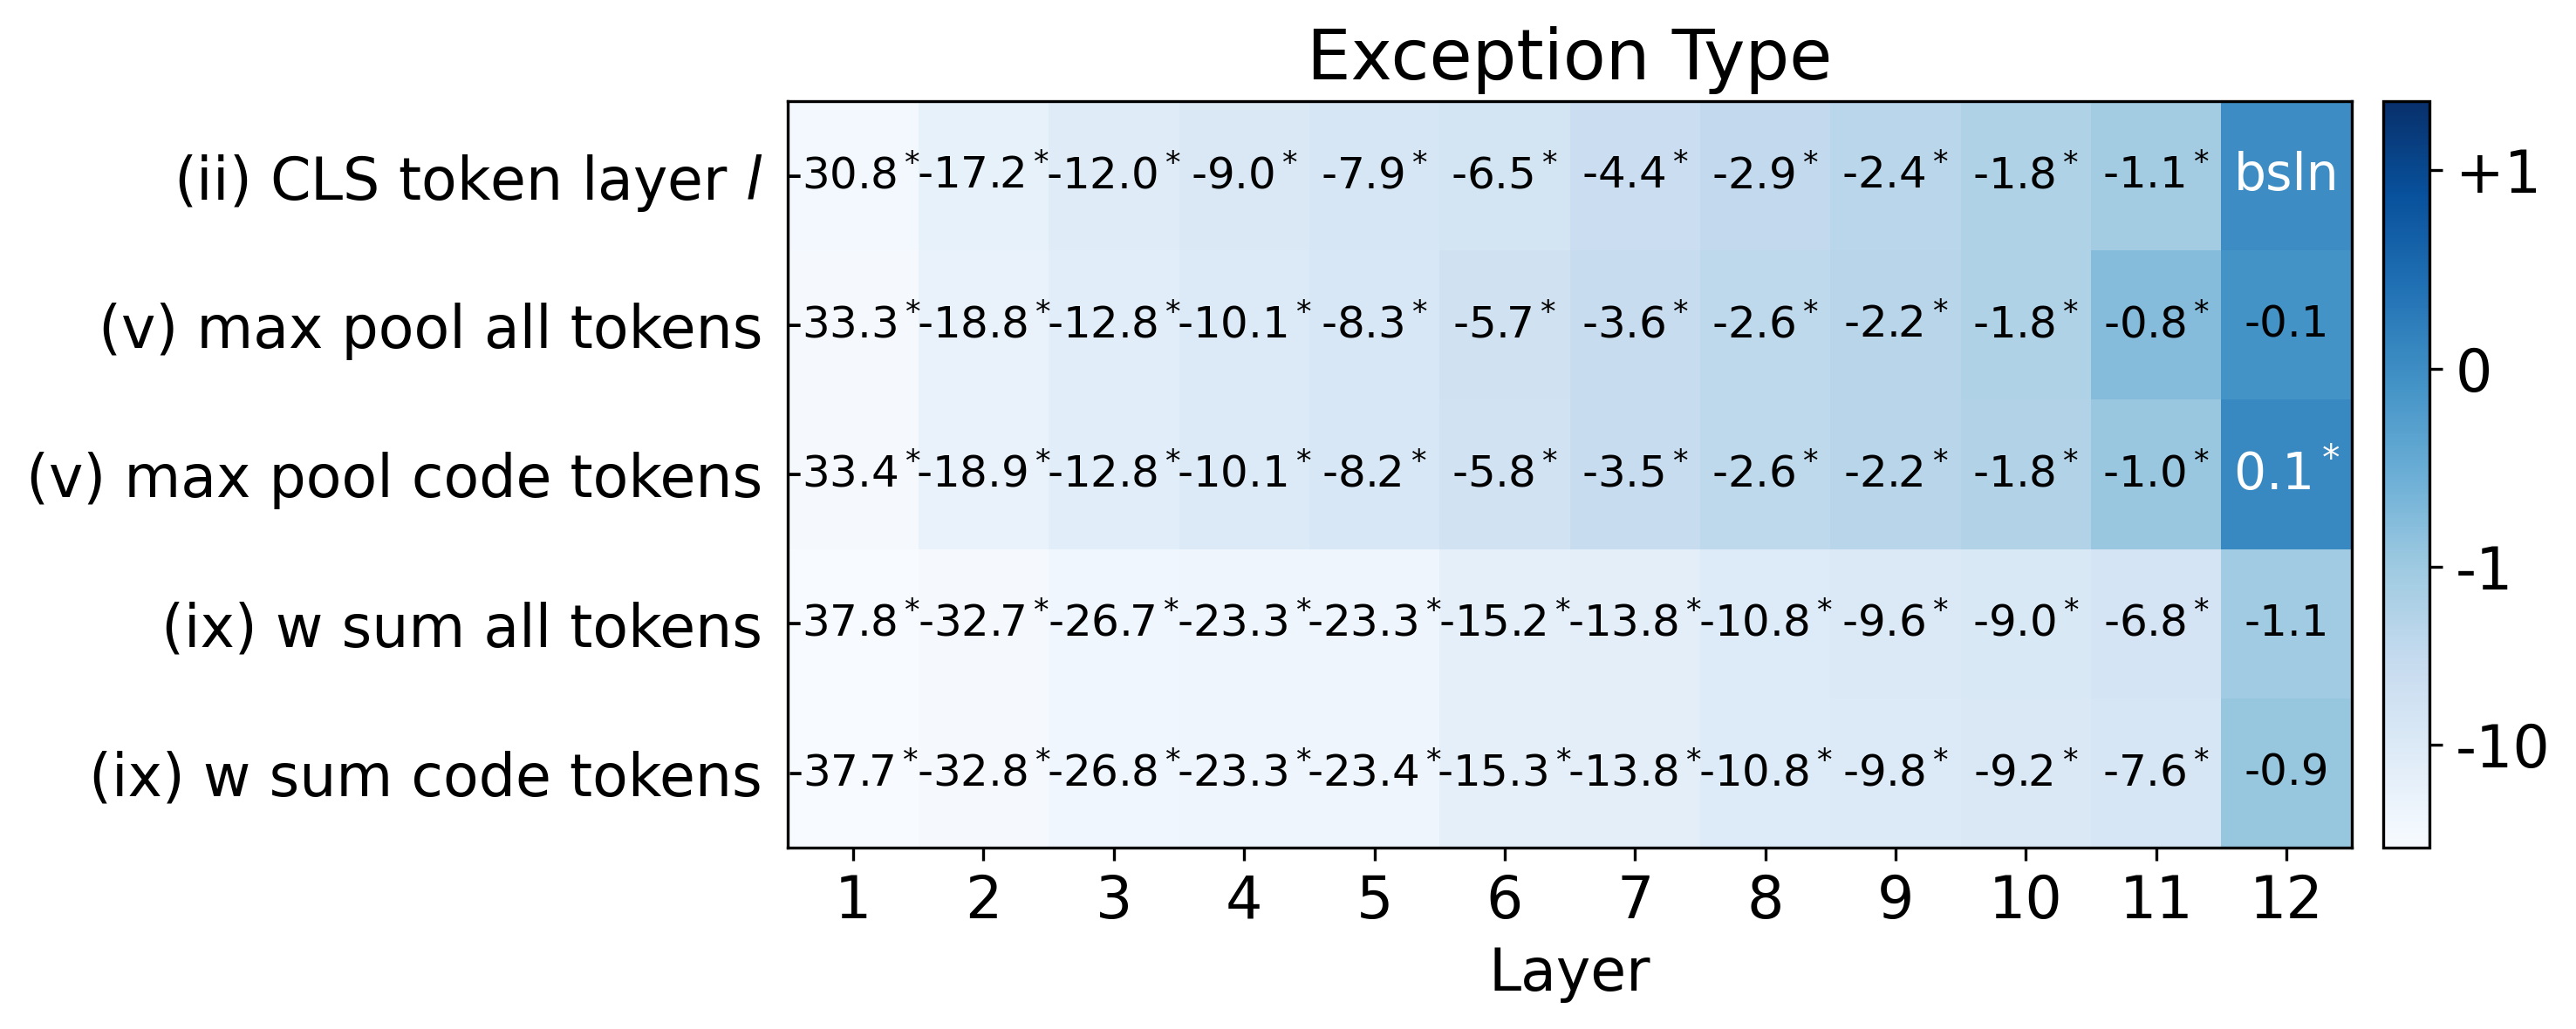

In [23]:
# Plots v3 - 4 on one line
import matplotlib.colors as colors
matplotlib.rcParams.update({'font.size': 16})

vmin = 100
vmax = -100

for metric in ['acc_test', 'f1_weighted_test']:
    for a, name in enumerate(experiment_names):

        df = dfs_one_layer[name][metric].copy()

        vmin = min(vmin, df.min().min())
        vmax = max(vmax, df.max().max())

    for a, name in enumerate(experiment_names):
        fig, axs = plt.subplots(nrows=1, ncols=1, dpi=300, figsize=(10, 4))

        df = dfs_one_layer[name][metric].copy()
        df.sort_index(ascending=True, inplace=True)

        im = axs.pcolormesh(df.values, norm=colors.SymLogNorm(linthresh=1, linscale=1,
                                                  vmin=vmin, vmax=vmax, base=10),
                           cmap='Blues')

        axs.set_title(f'{plot_experiment_names[name]}')

        axs.set_xticks(np.arange(0.5, len(df.columns)+0.5, 1), df.columns)

        axs.set_xlabel('Layer')
        axs.invert_yaxis()


        for i, row in enumerate(df.index):
            for j, col in enumerate(df.columns):
                
                # show all results
                split_point = 0
                if df.iloc[i, j] > split_point:
                    if round(df.iloc[i, j], 1) > split_point:
                        if dfs_one_layer_pvalues[name][metric].iloc[i, j] < alpha:
                            axs.text(j+0.5, i+0.5, f'$%.1f^*$' % df.iloc[i, j], ha="center", va="center", color="w", size=14)
                        else:
                            axs.text(j+0.5, i+0.5, f'%.1f' % df.iloc[i, j], ha="center", va="center", color="w", size=14)
                    elif not ('one_layer_cls' in row and j==11):
                        axs.text(j+0.5, i+0.5, f'%.2f' % df.iloc[i, j], ha="center", va="center", color="w", size=14)
                else:
                    color = "k"
                    size = 12
                    rotation = 0
                    if round(df.iloc[i, j], 1) < split_point:
                        if dfs_one_layer_pvalues[name][metric].iloc[i, j] < alpha:
                                axs.text(j+0.5, i+0.5, f'%.1f$^*$' % df.iloc[i, j], ha="center", va="center", color=color, size=size,
                                        rotation=rotation)
                        else:
                            axs.text(j+0.5, i+0.5, f'%.1f' % df.iloc[i, j], ha="center", va="center", color=color, size=size,
                                        rotation=rotation)
                    elif not ('one_layer_cls' in row and j==11):
                        axs.text(j+0.5, i+0.5, f'%.2f' % df.iloc[i, j], ha="center", va="center", color=color, size=size,
                                        rotation=rotation)
                # show all results
                        
            if 'one_layer_cls' in row and j==11:
                axs.text(j+0.5, i+0.5, 'bsln', ha="center", va="center", color="w", size=14)

        vmin = min(vmin, df.min().min())
        vmax = max(vmax, df.max().max())

        axs.set_yticks(np.arange(.5, len(df.index)+.5, 1), [heatmap_combination_names[c] for c in df.index])
        
        plt.tick_params(left = False)

        cax = axs.inset_axes([1.02, 0.0, 0.03, 1])
        cbar_ticks = [-10, -1, 0, 1]
        cbar = fig.colorbar(im, orientation="vertical", ax=axs, cax=cax, ticks=cbar_ticks)
        cbar.ax.set_yticklabels(['-10', '-1', '0', '+1'])

        fig.tight_layout(pad=0.6)
        filepath = output_dir / f'{name}_{metric}_one_layer_heatmap.pdf'
        plt.savefig(filepath, bbox_inches='tight')

        plt.show()  


# All layers
## Table

In [24]:
output_dir = plot_dir / 'heatmap_all_combinations'
if not output_dir.exists():
    output_dir.mkdir(parents=True, exist_ok=True)


c_baseline = 'one_layer_cls'
l_baseline = 12

sp_tokens  = False

dfs_all_layers = {}
dfs_all_layers_pvalues = {}


for name in experiment_names:
    dfs_all_layers[name] = {}
    dfs_all_layers_pvalues[name] = {}
    
for metric in ['acc_test', 'f1_weighted_test']:
    for func, func_name in zip([np.max, np.mean], ['max', 'mean']):
        for name in experiment_names:

            c_names = [c for c in combinations if not 'one_layer' in c]
            rows = [c for c in c_names if 'cls' in c] + \
                        [''.join(p).strip() for p in list(itertools.product([c for c in c_names if not 'cls' in c], 
                                                                     ['', sp_tokens_suffix]))]

            dfs_all_layers[name][metric] = pd.DataFrame(index=rows, columns=[12], data=0)
            dfs_all_layers_pvalues[name][metric] = dfs_all_layers[name][metric].copy()

            baseline_values = []
            for seed in seeds:
                baseline_values.append(
                    table[name].loc[(table[name].loc[:, 'params.combination_type'] == c_baseline) & \
                                    (table[name].loc[:, 'params.hidden_layer_to_use'] == 12) & \
                                    (table[name].loc[:, 'params.epochs'] == 10) & \
                                    (table[name].loc[:, 'params.not_special_tokens_to_zero'] == default_sp_tokens_to_zero) & \
                                    (table[name].loc[:, 'params.seed'] == seed), 
                                    f'metrics.{metric}'].values.tolist()[0])

            baseline_metric_mean = func(baseline_values)

            for c in c_names:
                l = 12

                sp_tokens_choice = [False] if 'cls' in c else [True, False]

                for sp_tokens in sp_tokens_choice:
                    row = c + sp_tokens_suffix if not sp_tokens and not 'cls' in c else c
                    combination_values = get_values(table, name, l, sp_tokens, c, f'metrics.{metric}')
                    combination_values_mean = func(combination_values)
                    dfs_all_layers[name][metric].loc[row, l] = (combination_values_mean - baseline_metric_mean) * 100

                    stat = wilcoxon(combination_values, baseline_values)
                    dfs_all_layers_pvalues[name][metric].loc[row, l] = stat.pvalue

            print(f'{name} {metric} {func_name} {baseline_metric_mean}')


            # max improvement
            max_improvement = dfs_all_layers[name][metric].max().max()
            row_max = [r for r in dfs_all_layers[name][metric].index if max_improvement == dfs_all_layers[name][metric].loc[r, :].max()]
            col_max = [r for r in dfs_all_layers[name][metric].columns if max_improvement == dfs_all_layers[name][metric].loc[:, r].max()]

            # save differences
            # dfs_all_layers[name][metric].to_excel(table_dir / f'{name}_{plot_metric_names[metric]}_variance_of_{func_name}_all_tokens.xlsx')
            # dfs_all_layers_pvalues[name][metric].to_excel(table_dir / f'{name}_{plot_metric_names[metric]}_pvalues_for_variance_of_{func_name}_all_tokens.xlsx')

devign acc_test max 0.6346998535871157
reveal acc_test max 0.907651715039578
bifi acc_test max 0.9693125207572236
exception acc_test max 0.7691341321994588
devign acc_test mean 0.6173865300146413
reveal acc_test mean 0.8915127528583995
bifi acc_test mean 0.9670009963467286
exception acc_test mean 0.7539427908774642
devign f1_weighted_test max 0.6330165297183509
reveal f1_weighted_test max 0.8920717448743095
bifi f1_weighted_test max 0.969309180352228
exception f1_weighted_test max 0.7675580653839469
devign f1_weighted_test mean 0.6040094266899342
reveal f1_weighted_test mean 0.88533908654633
bifi f1_weighted_test mean 0.9670115256608176
exception f1_weighted_test mean 0.7529717182391295


## Figure - all layers

In [25]:
name = 'devign'
dfs_all_layers[name]['acc_test']

,12
max_pool_cls,-0.014641
w_sum_cls,0.607613
max_pool_layers_max_pool_tokens,0.307467
max_pool_layers_max_pool_tokens_zero_out_sp_tokens,0.234261
max_pool_layers_w_sum_tokens,-7.060761
max_pool_layers_w_sum_tokens_zero_out_sp_tokens,-7.331625
max_pool_tokens_w_sum_layers,-7.532943
max_pool_tokens_w_sum_layers_zero_out_sp_tokens,-6.771596
w_sum_tokens_w_sum_layers,-4.202050
w_sum_tokens_w_sum_layers_zero_out_sp_tokens,-5.519766


In [26]:
dfs_all_layers[name]['f1_weighted_test']

,12
max_pool_cls,0.141317
w_sum_cls,0.747985
max_pool_layers_max_pool_tokens,0.555233
max_pool_layers_max_pool_tokens_zero_out_sp_tokens,0.392791
max_pool_layers_w_sum_tokens,-11.388753
max_pool_layers_w_sum_tokens_zero_out_sp_tokens,-11.737080
max_pool_tokens_w_sum_layers,-10.196233
max_pool_tokens_w_sum_layers_zero_out_sp_tokens,-10.548465
w_sum_tokens_w_sum_layers,-5.287147
w_sum_tokens_w_sum_layers_zero_out_sp_tokens,-7.769222


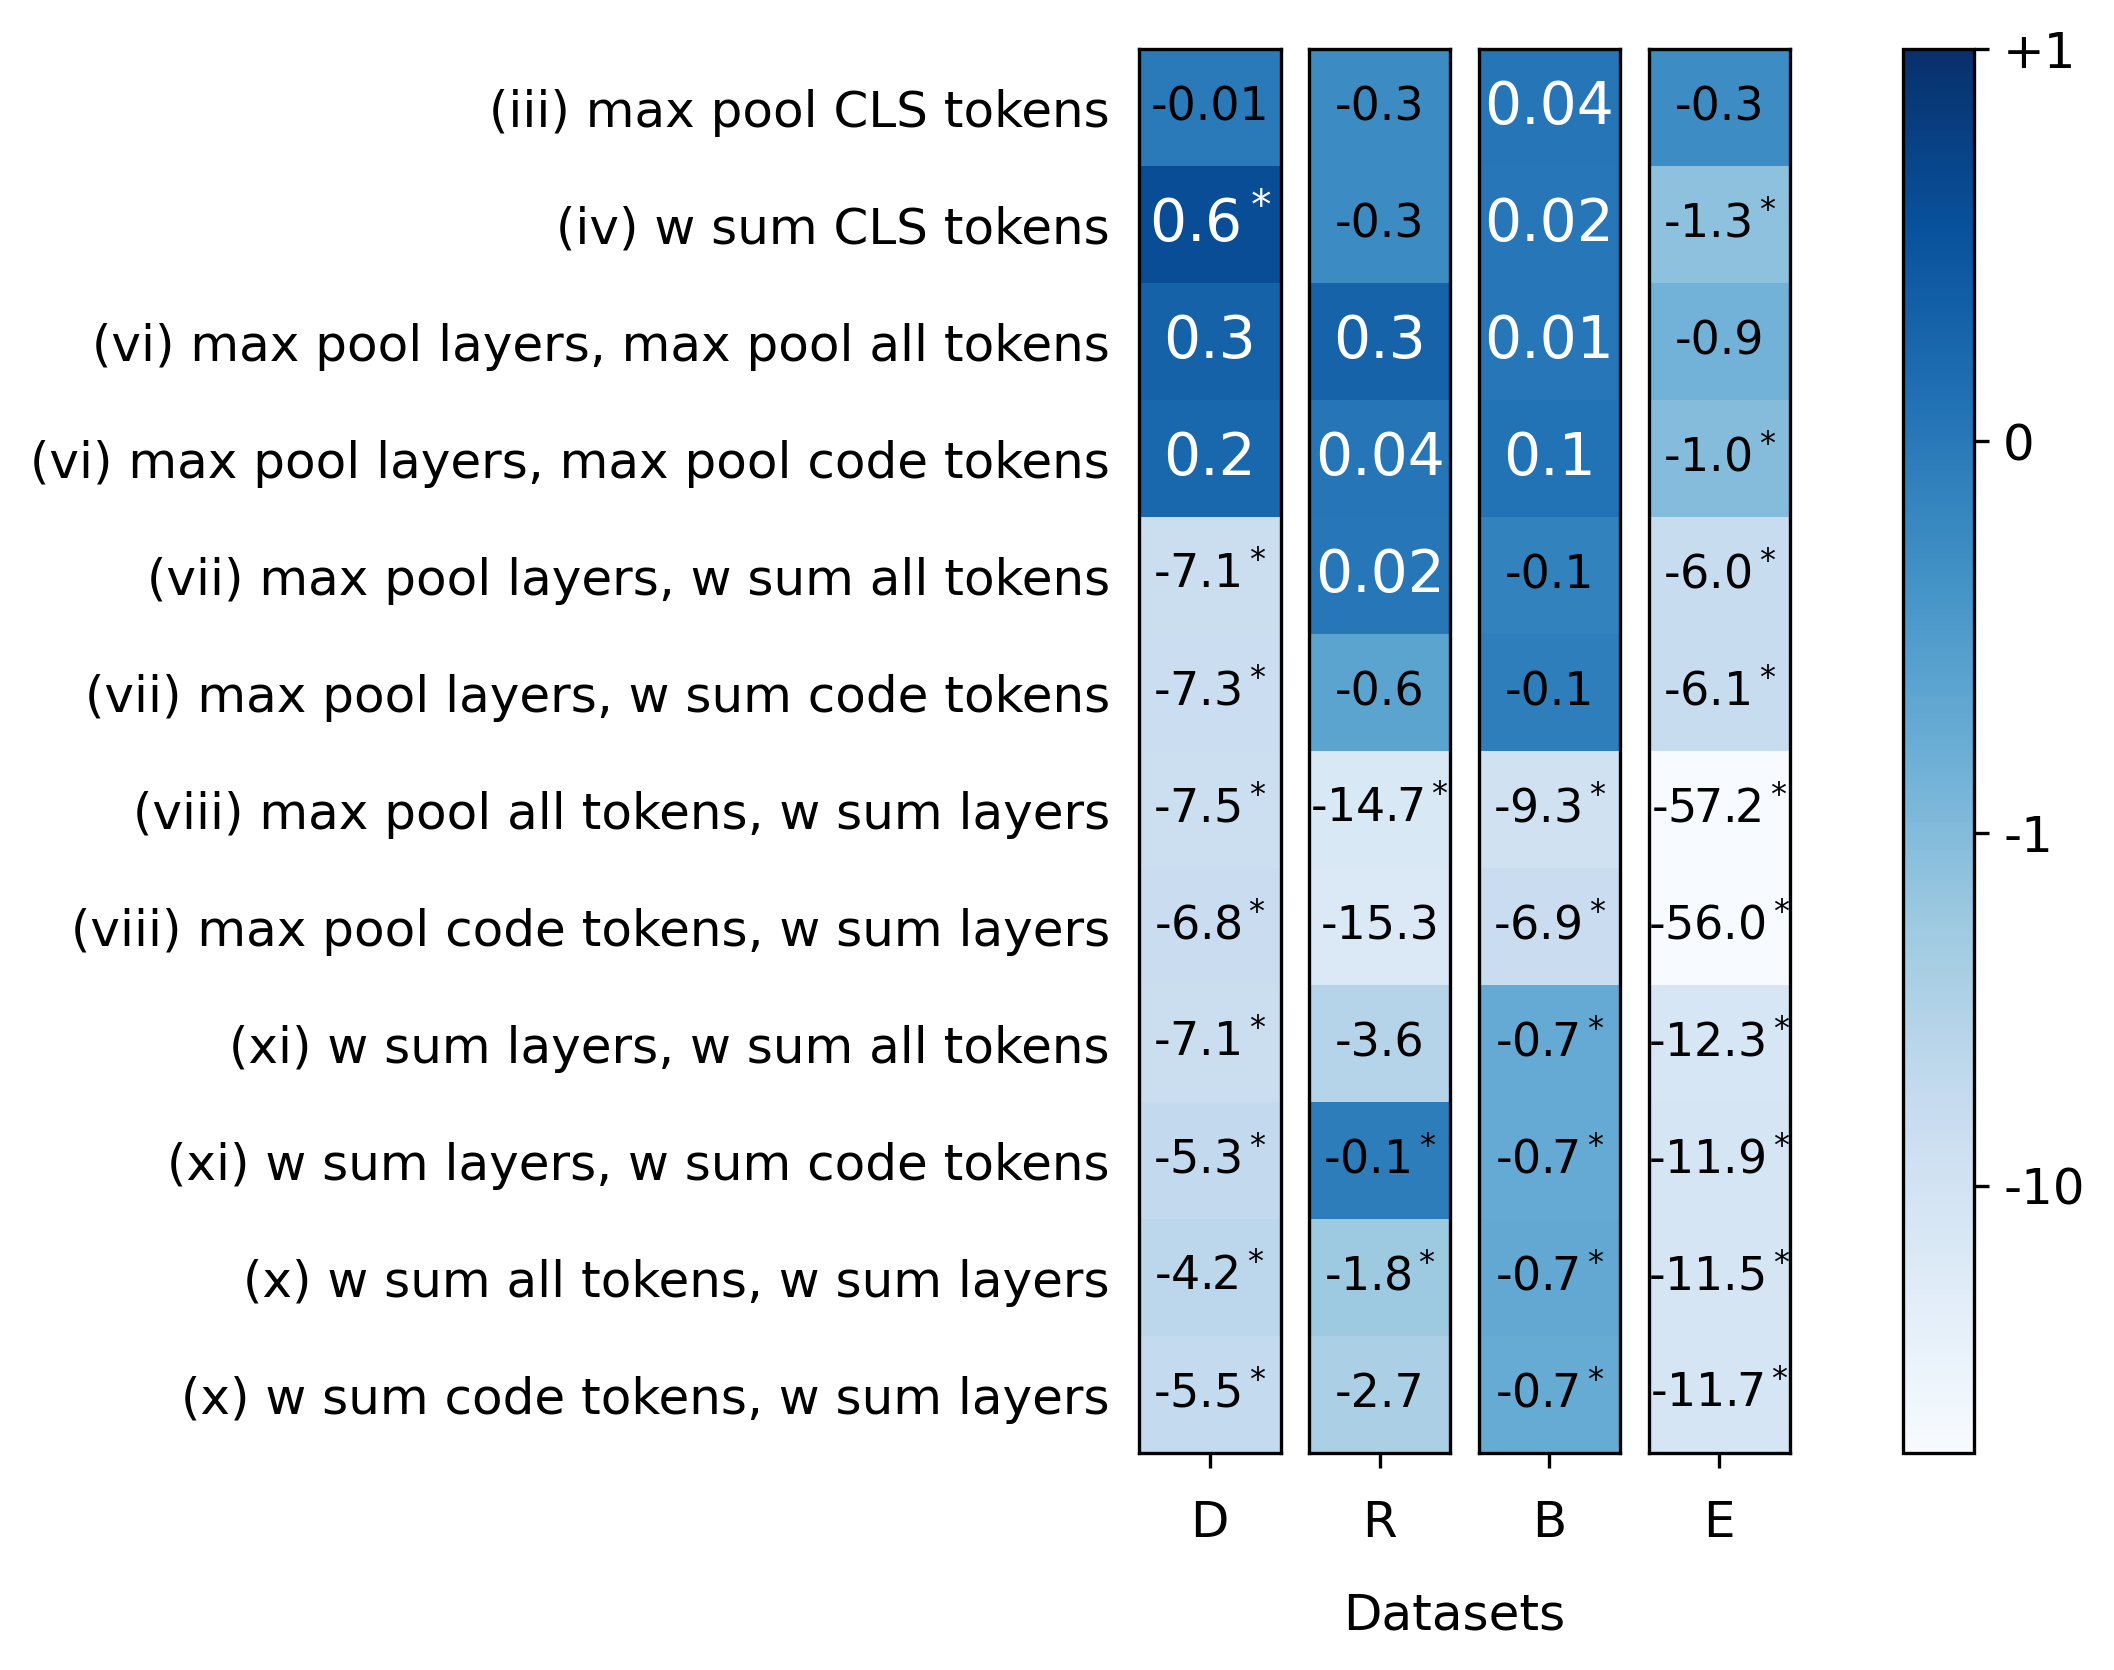

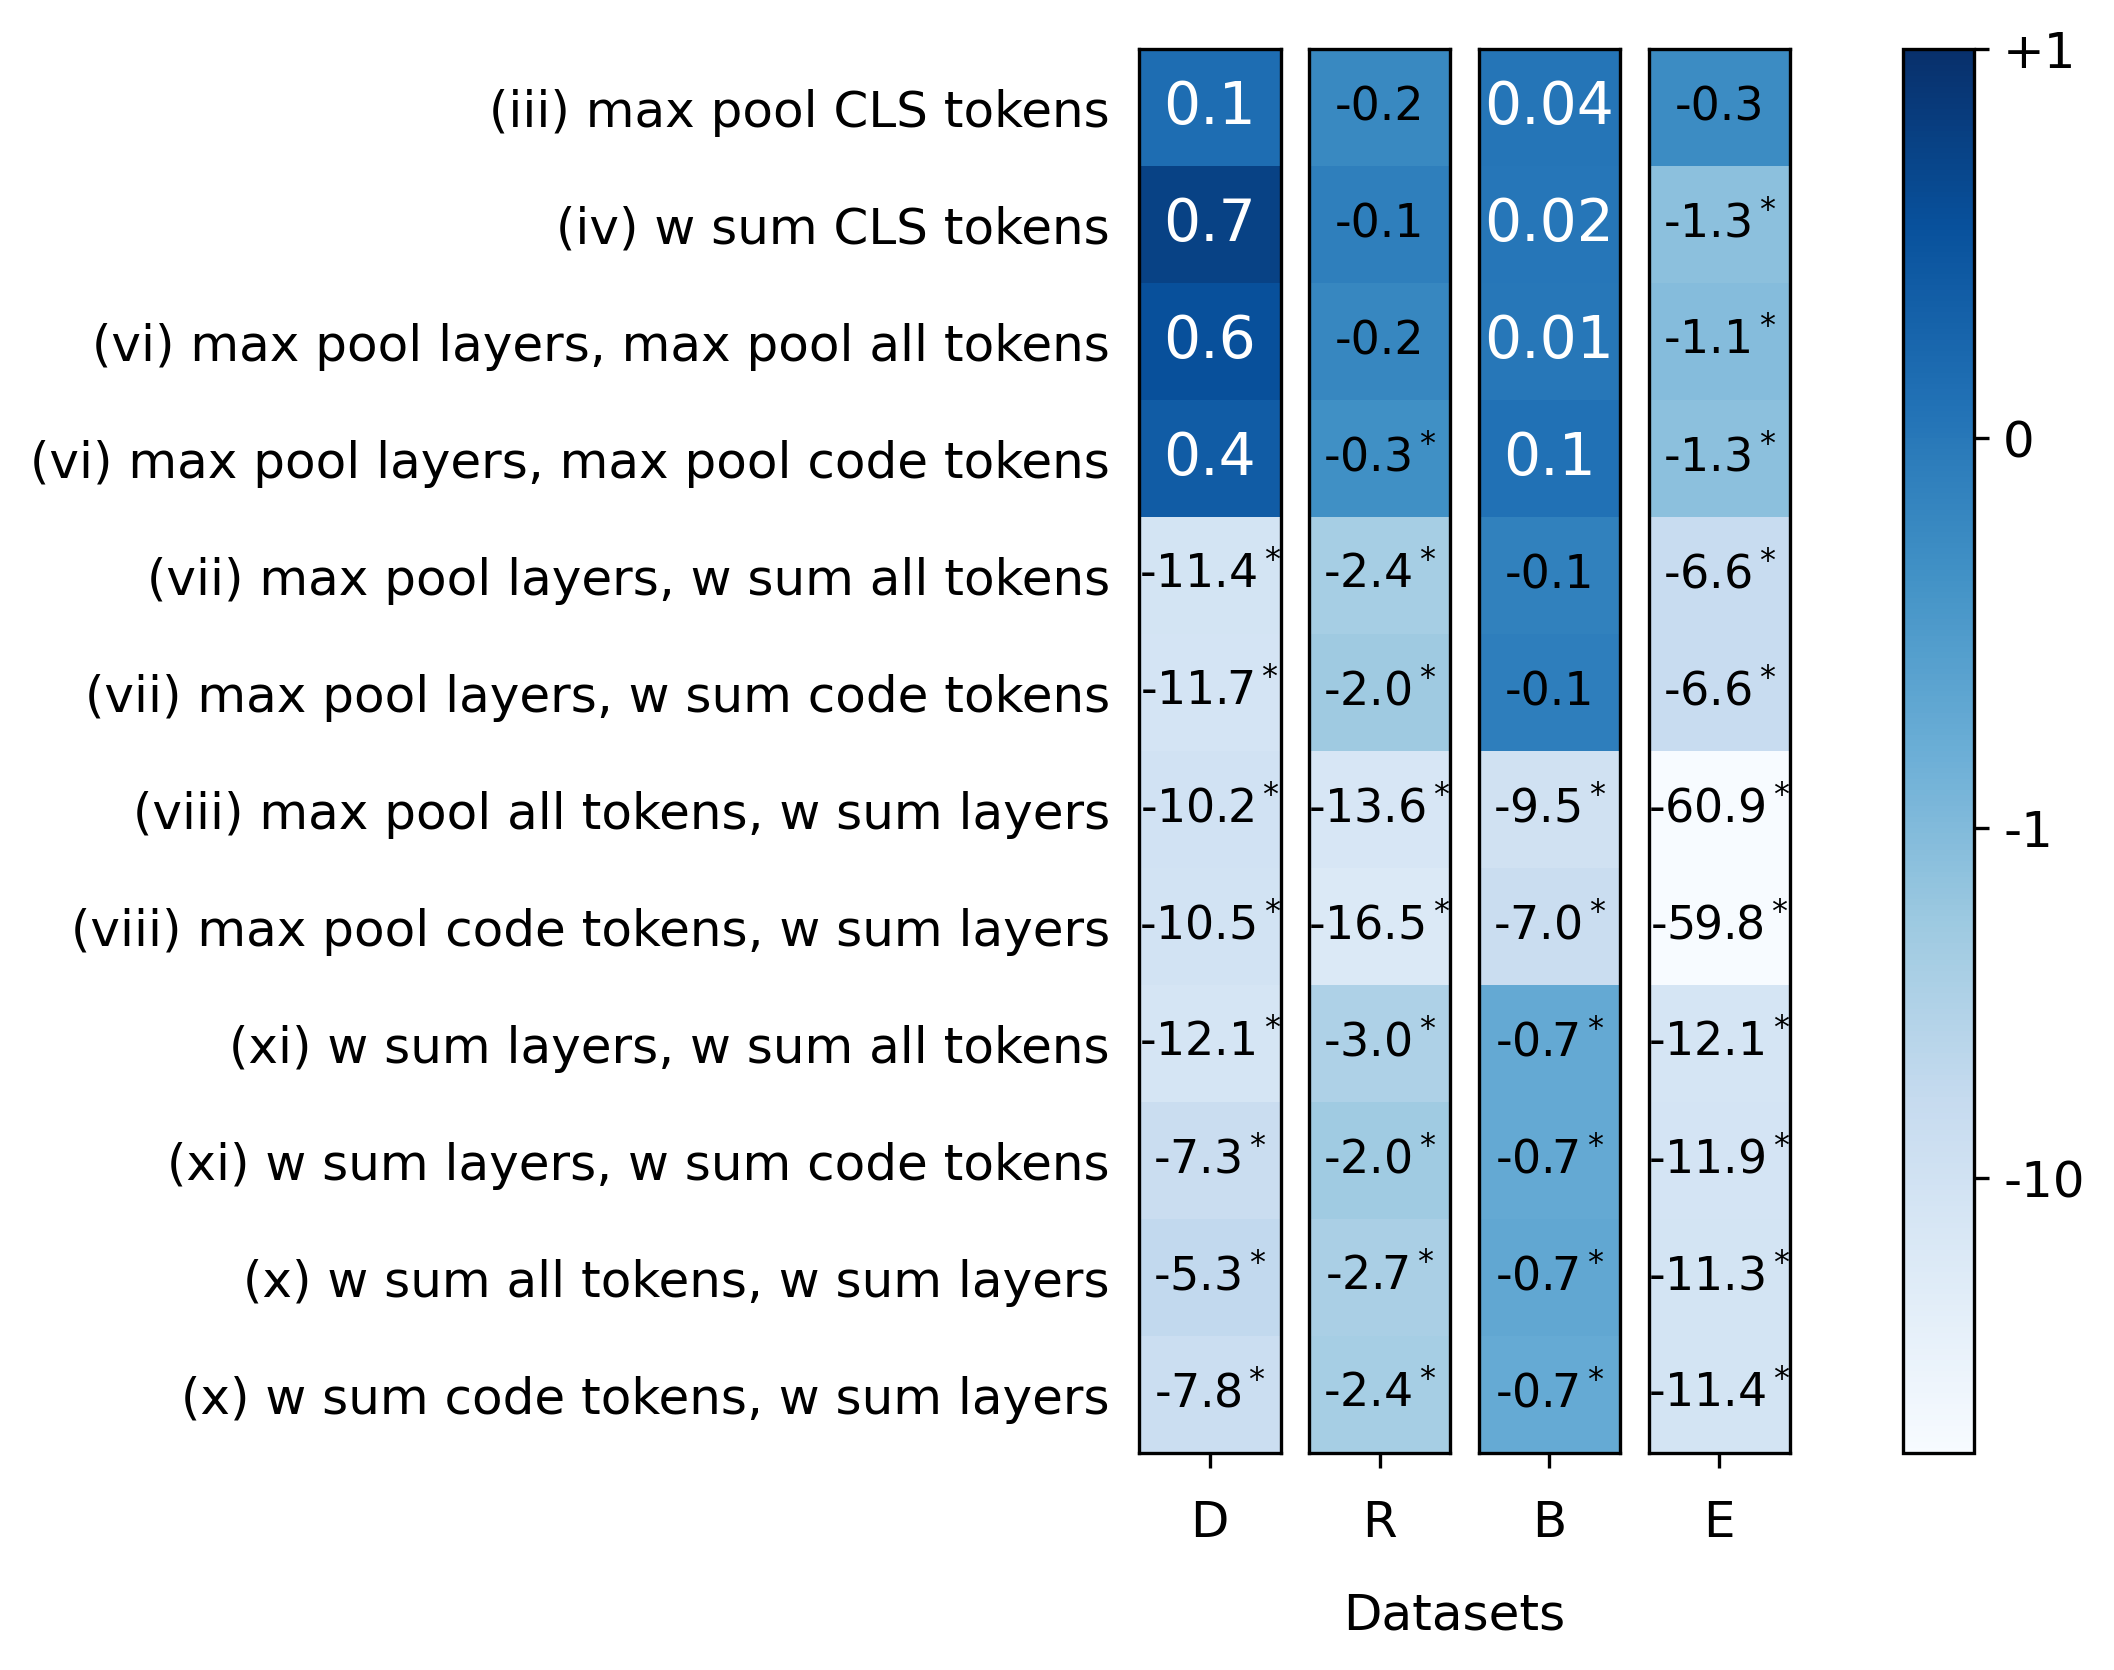

In [27]:
matplotlib.rcParams.update({'font.size': 12})

vmin = 100
vmax = -100

for metric in ['acc_test', 'f1_weighted_test']:
    fig, axs = plt.subplots(nrows=1, ncols=4, dpi=300, figsize=(2.8, 6.2)) 
    for a, name in enumerate(experiment_names):

        df = dfs_all_layers[name][metric].copy()

        vmin = min(vmin, df.min().min())

    for a, name in enumerate(experiment_names):

        df = dfs_all_layers[name][metric].copy()
        df = df.loc[[
        'max_pool_cls', 'w_sum_cls', 
        'max_pool_layers_max_pool_tokens',
        'max_pool_layers_max_pool_tokens_zero_out_sp_tokens',
        'max_pool_layers_w_sum_tokens',
        'max_pool_layers_w_sum_tokens_zero_out_sp_tokens',
        'max_pool_tokens_w_sum_layers',
        'max_pool_tokens_w_sum_layers_zero_out_sp_tokens',
        'w_sum_layers_w_sum_tokens',
        'w_sum_layers_w_sum_tokens_zero_out_sp_tokens',
        'w_sum_tokens_w_sum_layers',
        'w_sum_tokens_w_sum_layers_zero_out_sp_tokens'], :]


        im = axs[a].pcolormesh(df.values, norm=colors.SymLogNorm(linthresh=1, linscale=1,
                                                  vmin=vmin, vmax=1, base=10),
                           cmap='Blues')

        axs[a].set_xticks(np.arange(0.5, len(df.columns)+0.5, 1), [])
        axs[a].set_yticks(np.arange(0.5, len(df.index)+0.5, 1), [])
        axs[a].set_xlabel(f'{plot_experiment_names[name]}'[0])
        axs[a].invert_yaxis()


        for i, row in enumerate(df.index):
            for j, col in enumerate(df.columns):

                # show negative results, too 
                split_point = 0
                if df.iloc[i, j] > split_point:
                    if round(df.iloc[i, j], 1) > split_point:
                        if dfs_all_layers_pvalues[name][metric].iloc[i, j] < alpha:
                            axs[a].text(j+0.5, i+0.5, f'$%.1f^*$' % df.iloc[i, j], ha="center", va="center", color="w", size=14)
                        else:
                            axs[a].text(j+0.5, i+0.5, f'%.1f' % df.iloc[i, j], ha="center", va="center", color="w", size=14)
                    elif not ('one_layer_cls' in row and j==11):
                        axs[a].text(j+0.5, i+0.5, f'%.2f' % df.iloc[i, j], ha="center", va="center", color="w", size=14)
                else:
                    color = "k"
                    size = 11
                    rotation = 0
                    if round(df.iloc[i, j], 1) < split_point:
                        if dfs_all_layers_pvalues[name][metric].iloc[i, j] < alpha:
                                axs[a].text(j+0.5, i+0.5, f'%.1f$^*$' % df.iloc[i, j], ha="center", va="center", color=color, size=size,
                                        rotation=rotation)
                        else:
                            axs[a].text(j+0.5, i+0.5, f'%.1f' % df.iloc[i, j], ha="center", va="center", color=color, size=size,
                                        rotation=rotation)
                    elif not ('one_layer_cls' in row and j==11):
                        axs[a].text(j+0.5, i+0.5, f'%.2f' % df.iloc[i, j], ha="center", va="center", color=color, size=size,
                                        rotation=rotation)

        axs[a].tick_params(left = False)

        vmin = min(vmin, df.min().min())
        vmax = max(vmax, df.max().max())

    axs[0].set_yticks(np.arange(0.5, len(df.index)+0.5, 1), [heatmap_combination_names[c] for c in df.index])

    cax = axs[3].inset_axes([1.8, 0.0, 0.5, 1])
    cbar_ticks = [-10, -1, 0, 1]
    cbar = fig.colorbar(im, orientation="vertical", ax=axs[3], cax=cax, ticks=cbar_ticks)
    cbar.ax.set_yticklabels(['-10', '-1', '0', '+1'])
    
    fig.text(0.5, 0.03, 'Datasets', ha='center')

    fig.tight_layout(pad=0.1)
    filepath = output_dir / f'{metric}_all_tokens_heatmap.pdf'
    plt.savefig(filepath, bbox_inches='tight')

    plt.show()  

# End of notebook